In [682]:
#!/usr/bin/env python
from math import ceil
from random import uniform
import argparse
import os

import tensorflow as tf

from adain.nn import build_vgg, vgg_layer_params, build_decoder
from adain.norm import adain
from adain.util import get_params
from adain.weights import open_weights

import numpy as np
import numpy as np
import numba
from numba import njit, prange
from numba import cuda
import copy
import sys
import time
import matplotlib.pyplot as plt
import pydicom
import glob

from skimage.measure import label
from scipy.io import loadmat
from scipy.ndimage import zoom
#from scipy.misc import imresize
import pywt

import csv
import random
import time
%matplotlib inline  

from scipy import ndimage, misc

import pywt
#import hdf5storage

import scipy.io as sio
from skimage.filters import threshold_otsu


In [284]:
# All Imports

import numpy as np
import numba
from numba import njit, prange
from numba import cuda
import copy
import sys
import time
import matplotlib.pyplot as plt
import pydicom
import glob
from skimage import filters
from skimage.filters import unsharp_mask, threshold_local, threshold_minimum
import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import glob

from skimage.measure import compare_ssim as ssim



import numba
from numba import njit, prange

from keras import backend as K
from keras.layers import Layer

import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, Callback, TensorBoard
from keras import backend as keras

from skimage.measure import label
from scipy.io import loadmat
from scipy.ndimage import zoom
#from scipy.misc import imresize
import pywt

import csv
import random
import time
%matplotlib inline  

from scipy import ndimage, misc

import pywt
#import hdf5storage

import scipy.io as sio
from skimage.filters import threshold_otsu

#import pylidc as pl
#from keras.backend.tensorflow_backend import set_session
import tensorflow as tf


from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization

import pywt
import numpy as np
#import pydicom
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage.io as io
#from sklearn.decomposition import PCA
import collections, numpy
import warnings
from scipy import ndimage, misc
warnings.filterwarnings('ignore')

#import pymrt as mrt
#import pymrt.geometry
import ipyvolume as ipv
import copy


import os
import glob
import uuid
import numpy as np
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from ipdb import set_trace as bp



#from image_gen import ImageDataGenerator
#from load_data import loadDataMontgomery, loadDataJSRT
#from build_model import build_UNet2D_4L

import pandas as pd
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint



import numpy
import warnings
from keras.layers import Convolution3D, Input, merge, RepeatVector, Activation
from keras.models import Model
from keras.layers.advanced_activations import PReLU
from keras import activations, initializers, regularizers
from keras.engine import Layer, InputSpec
from keras.utils.conv_utils import conv_output_length
#from keras.utils.np_utils import conv_output_length
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.engine.topology import Layer
import functools
import tensorflow as tf
import pickle
import time

Using TensorFlow backend.


In [247]:
# Train Code

x_array = np.load("x_array.npy")
y_array = np.load("y_array.npy")
z_array = np.load("z_array.npy")

def get_my_batch():
    global x_array, y_array
    
    perm    = np.random.permutation(len(x_array))
    x_array = np.array(x_array)[perm]
    y_array = np.array(y_array)[perm]
    
    content_images = []
    style_images   = []
    
    for i in range(8):
        temp = [x_array[i, :, :, 0], x_array[i, :, :, 0], x_array[i, :, :, 0]]
        content_images.append(temp)
        
        temp = [y_array[i, :, :, 0], y_array[i, :, :, 0], y_array[i, :, :, 0]]
        style_images.append(temp)
       
    #content_images = x_array[:8, :, :, 0]
    #style_images   = y_array[:8, :, :, 0]
    
    #content_images = np.concatenate([content_images, content_images, content_images], axis=-1)
    #style_images   = np.concatenate([style_images, style_images, style_images], axis=-1)
    
    return np.array(content_images)*5, np.array(style_images)*5
    

def train(
        content_dir='datasets/coco',
        style_dir='datasets/wikiart',
        checkpoint_dir='checkpoints',
        decoder_activation='relu',
        initial_size=512,
        random_crop_size=256,
        resume=True,
        optimizer='adam',
        learning_rate=1e-5,
        learning_rate_decay=0,#5e-5,
        momentum=0.9,
        batch_size=8,
        num_epochs=16,
        content_layer='conv4_1',
        style_layers='conv1_1,conv2_1,conv3_1,conv4_1',
        tv_weight=0,
        style_weight=0.0001,
        content_weight=1,
        save_every=2000,
        print_every=10,
        gpu=0,
        vgg='models/vgg19_weights_normalized.h5'):
    
    tf.reset_default_graph()
    #assert initial_size >= random_crop_size, 'Images are too small to be cropped'
    #assert gpu >= 0, 'CPU mode is not supported'

    #os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
    
    #if not os.path.exists(checkpoint_dir):
    #    print('Creating checkpoint dir at', checkpoint_dir)
    #    os.mkdir(checkpoint_dir)

    style_layers = style_layers.split(',')
    
    # the content layer is also used as the encoder layer
    encoder_layer = content_layer
    encoder_layer_filters = vgg_layer_params(encoder_layer)['filters']
    encoder_layer_shape   = (None, encoder_layer_filters, None, None)


    # decoder->encoder setup
    if decoder_activation == 'relu':
        decoder_activation = tf.nn.relu
    elif decoder_activation == 'elu':
        decoder_activation = tf.nn.elu
    else:
        raise ValueError('Unknown activation: ' + decoder_activation)
    
    input_image_shape = (None, 3, 128, 128)
    
    for_mae_loss    = tf.placeholder(tf.float32, shape=input_image_shape)
    
    content_encoded = tf.placeholder(tf.float32, shape=encoder_layer_shape)
    style_encoded   = tf.placeholder(tf.float32, shape=encoder_layer_shape)
    output_encoded  = adain(content_encoded, style_encoded)
    
    images = build_decoder(output_encoded, weights=None, trainable=True,
        activation=decoder_activation)
    
    #print(images, tf.shape(images))
    #return
    
    with open_weights(vgg) as w:
        vgg     = build_vgg(images, w, last_layer=encoder_layer)
        encoder = vgg[encoder_layer]


    # loss setup
    # content_target, style_targets will hold activations of content and style
    # images respectively
    content_layer  = vgg[content_layer]
    content_target = tf.placeholder(tf.float32, shape=encoder_layer_shape)
    
    style_layers = {layer: vgg[layer] for layer in style_layers}
    style_targets = {
        layer: tf.placeholder(tf.float32, shape=style_layers[layer].shape)
        for layer in style_layers
    }

    content_loss = build_content_loss(content_layer, content_target, content_weight)
    style_losses = build_style_losses(style_layers, style_targets, style_weight)
    
    #loss = content_loss + tf.reduce_sum(list(style_losses.values()))
    
    
    if tv_weight:
        tv_loss = tf.reduce_sum(tf.image.total_variation(images)) * tv_weight
    else:
        tv_loss = tf.constant(0, dtype=tf.float32)
    #loss += tv_loss
    
    loss = tf.reduce_sum(tf.keras.losses.mean_absolute_error(for_mae_loss, images))
    #loss    += 0.01*mae_loss 

    # training setup
    #batch = setup_input_pipeline(content_dir, style_dir, batch_size,
    #    num_epochs, initial_size, random_crop_size)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    rate = tf.train.inverse_time_decay(learning_rate, global_step,
        decay_steps=1, decay_rate=learning_rate_decay)

    if optimizer == 'adam':
        optimizer = tf.train.AdamOptimizer(rate, beta1=momentum)
    elif optimizer == 'sgd':
        optimizer = tf.train.GradientDescentOptimizer(rate)
    else:
        raise ValueError('Unknown optimizer: ' + optimizer)

    train_op = optimizer.minimize(loss, global_step=global_step)

    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.local_variables_initializer())

        if resume:
            latest = tf.train.latest_checkpoint(checkpoint_dir)
            saver.restore(sess, latest)
        else:
            sess.run(tf.global_variables_initializer())

        coord   = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        with coord.stop_on_exception():
            while not coord.should_stop():
                content_batch, style_batch = get_my_batch()
                #content_batch, style_batch = sess.run(batch)

                # step 1
                # encode content and style images,
                # compute target style activations,
                # run content and style through AdaIN
                content_batch_encoded = sess.run(encoder, feed_dict={
                    images: content_batch
                })

                style_batch_encoded, style_target_vals = sess.run([encoder, style_layers], feed_dict={
                    images: style_batch
                })

                output_batch_encoded = sess.run(output_encoded, feed_dict={
                    content_encoded: content_batch_encoded,
                    style_encoded: style_batch_encoded
                })

                # step 2
                # run the output batch through the decoder, compute loss
                feed_dict = {
                    output_encoded: output_batch_encoded,
                    # "We use the AdaIN output as the content target, instead of
                    # the commonly used feature responses of the content image"
                    content_target: output_batch_encoded
                }
                for layer in style_targets:
                    feed_dict[style_targets[layer]] = style_target_vals[layer]
                
                feed_dict[for_mae_loss] = style_batch
                
                #allkeys = feed_dict.keys()
                #print("All keys are")
                #for kt in allkeys:
                #    print(kt)
                #print()
                #return 0, 1, 2
                
                fetches = [train_op, loss, content_loss, style_losses, tv_loss, global_step, images]
                result  = sess.run(fetches, feed_dict=feed_dict)
                _, loss_val, content_loss_val, style_loss_vals, tv_loss_val, i, output_result = result
                
                #print("MAE loss is ", mae_loss_val)
                
                if i % print_every == 0:
                    style_loss_val  = sum(style_loss_vals.values())
                    style_loss_vals = '\t'.join(sorted(['%s = %0.4f' % (name, val) for name, val in style_loss_vals.items()]))
                    print(i,
                        'loss = %0.4f' % loss_val,
                        'content = %0.4f' % content_loss_val,
                        'style = %0.4f' % style_loss_val,
                        style_loss_vals,
                        'tv = %0.4f' % tv_loss_val, sep='\t')
                    print(output_result.shape, np.mean(output_result), np.mean(content_batch), np.mean(style_batch))

                if i % save_every == 0:
                    print('Saving checkpoint')
                    saver.save(sess, os.path.join(checkpoint_dir, 'adain'), global_step=i)

        coord.join(threads)
        saver.save(sess, os.path.join(checkpoint_dir, 'adain-final'))


def build_content_loss(current, target, weight):
    loss = tf.reduce_mean(tf.squared_difference(current, target))
    loss *= weight
    return loss


def build_style_losses(current_layers, target_layers, weight, epsilon=1e-6):
    losses = {}
    for layer in current_layers:
        current, target = current_layers[layer], target_layers[layer]

        current_mean, current_var = tf.nn.moments(current, axes=[2,3], keep_dims=True)
        current_std = tf.sqrt(current_var + epsilon)

        target_mean, target_var = tf.nn.moments(target, axes=[2,3], keep_dims=True)
        target_std = tf.sqrt(target_var + epsilon)

        #diff_loss = tf.reduce_sum(tf.squared_difference(current, target))
        mean_loss = tf.reduce_sum(tf.squared_difference(current_mean, target_mean))
        std_loss = tf.reduce_sum(tf.squared_difference(current_std, target_std))

        # normalize w.r.t batch size
        n = tf.cast(tf.shape(current)[0], dtype=tf.float32)
        
        #diff_loss /= n
        mean_loss /= n
        std_loss /= n
        
        #losses[layer] = diff_loss * weight
        losses[layer] = (mean_loss + std_loss) * weight
    return losses



In [248]:
train()

INFO:tensorflow:Restoring parameters from checkpoints/adain-252000
252010	loss = 12.6439	content = 0.0687	style = 0.0020	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0011	tv = 0.0000
(8, 3, 128, 128) 0.44732162 0.4468 0.4473
252020	loss = 13.8529	content = 0.0282	style = 0.0016	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46008158 0.46 0.46
252030	loss = 11.6341	content = 0.0338	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46724343 0.4668 0.467
252040	loss = 11.5631	content = 0.0493	style = 0.0018	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.45696494 0.4565 0.457
252050	loss = 16.7676	content = 0.0372	style = 0.0022	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0009	conv4_1 = 0.0012	tv = 0.0000
(8, 3, 128, 128) 0.47672498 0.4766 0.4768
252060	loss = 9.8378	content = 0.0243	style = 0.0012	conv1_

252480	loss = 9.3588	content = 0.0377	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.46098295 0.46 0.4607
252490	loss = 11.1074	content = 0.0417	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.450694 0.4504 0.4507
252500	loss = 10.8603	content = 0.0367	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.48141548 0.4807 0.4817
252510	loss = 9.0406	content = 0.0557	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.37454656 0.3745 0.3745
252520	loss = 13.2540	content = 0.0432	style = 0.0019	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.48285422 0.4824 0.483
252530	loss = 10.7073	content = 0.0386	style = 0.0020	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0010	tv = 

252950	loss = 7.9145	content = 0.0514	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.46540377 0.4648 0.4653
252960	loss = 10.2645	content = 0.0414	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46297634 0.4622 0.4626
252970	loss = 14.7768	content = 0.0312	style = 0.0018	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.473279 0.4731 0.4731
252980	loss = 8.4268	content = 0.0264	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.47145787 0.471 0.4714
252990	loss = 8.5008	content = 0.0395	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.44509518 0.4446 0.445
253000	loss = 9.9423	content = 0.0254	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0

253420	loss = 9.3097	content = 0.0344	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.41228524 0.4124 0.4124
253430	loss = 6.5556	content = 0.0220	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.4653168 0.465 0.4653
253440	loss = 12.4817	content = 0.0311	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46644187 0.4663 0.4663
253450	loss = 14.6148	content = 0.0352	style = 0.0020	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.4744792 0.474 0.4744
253460	loss = 14.8327	content = 0.0382	style = 0.0021	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0009	conv4_1 = 0.0011	tv = 0.0000
(8, 3, 128, 128) 0.4755061 0.475 0.4753
253470	loss = 13.7832	content = 0.0561	style = 0.0022	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0009	conv4_1 = 0.0012	tv = 0

253890	loss = 12.0163	content = 0.0300	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.45777988 0.4578 0.4578
253900	loss = 11.6582	content = 0.0486	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.40401614 0.4036 0.4038
253910	loss = 11.4390	content = 0.0293	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47694668 0.4768 0.4768
253920	loss = 10.6252	content = 0.0332	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4503835 0.4504 0.4504
253930	loss = 8.6238	content = 0.0285	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.45611247 0.4553 0.4558
253940	loss = 7.8305	content = 0.0290	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	t

254360	loss = 16.6512	content = 0.0440	style = 0.0018	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.43161908 0.4314 0.4314
254370	loss = 9.6908	content = 0.0490	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.46104273 0.4604 0.4612
254380	loss = 9.5142	content = 0.0248	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.46096292 0.461 0.4612
254390	loss = 9.4866	content = 0.0433	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4258988 0.426 0.426
254400	loss = 10.0088	content = 0.0248	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.458266 0.4583 0.4585
254410	loss = 8.1821	content = 0.0384	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0

254830	loss = 13.3398	content = 0.0356	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.46432915 0.4644 0.4646
254840	loss = 12.0330	content = 0.0353	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46266666 0.4626 0.463
254850	loss = 9.2932	content = 0.0346	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.43745902 0.4373 0.4375
254860	loss = 8.7710	content = 0.0631	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4219966 0.4211 0.4219
254870	loss = 9.4441	content = 0.0380	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4765763 0.476 0.4766
254880	loss = 10.4104	content = 0.0279	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 

255300	loss = 14.1453	content = 0.0350	style = 0.0018	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.4755101 0.475 0.4756
255310	loss = 14.6918	content = 0.0349	style = 0.0019	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.48259696 0.4824 0.4827
255320	loss = 6.7890	content = 0.0392	style = 0.0007	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.41337368 0.4136 0.4133
255330	loss = 10.8328	content = 0.0278	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47559676 0.4758 0.4758
255340	loss = 11.7210	content = 0.0434	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46362638 0.4631 0.4636
255350	loss = 11.3463	content = 0.0276	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	t

255770	loss = 9.0206	content = 0.0228	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4618084 0.4614 0.4617
255780	loss = 15.2734	content = 0.0404	style = 0.0018	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0012	tv = 0.0000
(8, 3, 128, 128) 0.44732425 0.447 0.4473
255790	loss = 8.9389	content = 0.0274	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.4614614 0.461 0.4612
255800	loss = 13.0937	content = 0.0612	style = 0.0019	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0012	tv = 0.0000
(8, 3, 128, 128) 0.41224936 0.4124 0.4126
255810	loss = 9.9984	content = 0.0287	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46894956 0.4688 0.4688
255820	loss = 11.9749	content = 0.0318	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 

256240	loss = 9.6408	content = 0.0239	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46796012 0.4675 0.4678
256250	loss = 10.5911	content = 0.0625	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.45630944 0.4553 0.4563
256260	loss = 10.5109	content = 0.0520	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.44585046 0.446 0.446
256270	loss = 16.1681	content = 0.0639	style = 0.0024	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0009	conv4_1 = 0.0013	tv = 0.0000
(8, 3, 128, 128) 0.4311436 0.431 0.4314
256280	loss = 10.6195	content = 0.0367	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46216914 0.4617 0.4622
256290	loss = 8.6515	content = 0.0231	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv =

256710	loss = 11.3773	content = 0.0254	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.45040226 0.4502 0.4504
256720	loss = 9.0666	content = 0.0354	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45872068 0.4585 0.459
256730	loss = 6.6517	content = 0.0269	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.47220907 0.4714 0.4722
256740	loss = 12.6986	content = 0.0487	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.45874417 0.458 0.4587
256750	loss = 8.7522	content = 0.0238	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.4501742 0.45 0.4502
256760	loss = 11.5072	content = 0.0350	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0

257180	loss = 6.1121	content = 0.0416	style = 0.0006	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0002	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.43544343 0.4348 0.4353
257190	loss = 15.5459	content = 0.0385	style = 0.0015	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4380244 0.438 0.438
257200	loss = 9.1147	content = 0.0361	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.45062944 0.45 0.4504
257210	loss = 13.1867	content = 0.0268	style = 0.0014	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.45936015 0.4592 0.4595
257220	loss = 13.8995	content = 0.0410	style = 0.0018	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.46668446 0.4666 0.4668
257230	loss = 13.3076	content = 0.0353	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 

257650	loss = 16.4378	content = 0.0409	style = 0.0021	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0011	tv = 0.0000
(8, 3, 128, 128) 0.47907257 0.4785 0.479
257660	loss = 11.5381	content = 0.0323	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46699026 0.4668 0.467
257670	loss = 9.2285	content = 0.0336	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.47214448 0.4714 0.4722
257680	loss = 12.2520	content = 0.0452	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.44870242 0.4482 0.4487
257690	loss = 6.2083	content = 0.0170	style = 0.0007	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.4599965 0.46 0.46
257700	loss = 14.8359	content = 0.0438	style = 0.0018	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.

258120	loss = 19.7232	content = 0.0473	style = 0.0024	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0013	tv = 0.0000
(8, 3, 128, 128) 0.44907293 0.4492 0.4492
258130	loss = 13.9858	content = 0.0351	style = 0.0018	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.47618303 0.4758 0.476
258140	loss = 13.5410	content = 0.0444	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4462856 0.446 0.4463
258150	loss = 12.0535	content = 0.0360	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.45095798 0.4512 0.4512
258160	loss = 10.0833	content = 0.0268	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46877134 0.4685 0.4688
258170	loss = 11.4878	content = 0.0242	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	t

258590	loss = 6.8000	content = 0.0256	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.46562985 0.4656 0.4656
258600	loss = 12.8747	content = 0.0425	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.45417938 0.4539 0.454
258610	loss = 10.6463	content = 0.0311	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.473487 0.4731 0.4731
258620	loss = 9.2370	content = 0.0367	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4742529 0.4734 0.4744
258630	loss = 8.1038	content = 0.0240	style = 0.0007	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.43658197 0.4365 0.4368
258640	loss = 11.0729	content = 0.0441	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 

259060	loss = 13.6625	content = 0.0372	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.4746313 0.474 0.4744
259070	loss = 9.2945	content = 0.0252	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4672008 0.467 0.4673
259080	loss = 8.5397	content = 0.0247	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.47089848 0.4705 0.471
259090	loss = 6.0886	content = 0.0256	style = 0.0008	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.46788594 0.4675 0.4678
259100	loss = 11.9672	content = 0.0428	style = 0.0018	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.48116693 0.481 0.4812
259110	loss = 9.3457	content = 0.0415	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0006	conv4_1 = 0.0007	tv = 0.0

259530	loss = 7.1475	content = 0.0375	style = 0.0008	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.43203428 0.432 0.432
259540	loss = 11.2786	content = 0.0269	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4729363 0.4727 0.473
259550	loss = 6.7289	content = 0.0335	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.46377647 0.4636 0.464
259560	loss = 9.6598	content = 0.0336	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46899828 0.4688 0.469
259570	loss = 9.7011	content = 0.0248	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4720368 0.4722 0.4722
259580	loss = 12.0376	content = 0.0537	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.00

260000	loss = 9.1159	content = 0.0538	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.42826882 0.4272 0.4282
Saving checkpoint
260010	loss = 7.1613	content = 0.0214	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.47146162 0.4712 0.4714
260020	loss = 11.4474	content = 0.0478	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.43594217 0.4355 0.4358
260030	loss = 12.4371	content = 0.0281	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47449136 0.4744 0.4746
260040	loss = 14.5042	content = 0.0346	style = 0.0020	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0011	tv = 0.0000
(8, 3, 128, 128) 0.4742457 0.474 0.474
260050	loss = 14.4779	content = 0.0603	style = 0.0023	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0009	co

260470	loss = 13.8184	content = 0.0379	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.47955206 0.479 0.4797
260480	loss = 9.7958	content = 0.0483	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4308635 0.431 0.4312
260490	loss = 9.0751	content = 0.0238	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.4522785 0.4521 0.4521
260500	loss = 6.5453	content = 0.0274	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.47422734 0.4731 0.4739
260510	loss = 8.7774	content = 0.0537	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.41888633 0.4187 0.4192
260520	loss = 8.0711	content = 0.0350	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.

260940	loss = 12.0599	content = 0.0392	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46765926 0.4675 0.4678
260950	loss = 7.9914	content = 0.0492	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.42560387 0.425 0.4255
260960	loss = 8.3842	content = 0.0372	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.46228993 0.462 0.4624
260970	loss = 11.6070	content = 0.0349	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.45971298 0.46 0.46
260980	loss = 9.8588	content = 0.0296	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.47035363 0.4692 0.4702
260990	loss = 11.8231	content = 0.0361	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.

261410	loss = 12.6809	content = 0.0303	style = 0.0017	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.48062387 0.4807 0.4807
261420	loss = 10.8173	content = 0.0260	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.45652965 0.4565 0.4565
261430	loss = 9.8982	content = 0.0219	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.46943304 0.4695 0.4695
261440	loss = 8.6711	content = 0.0234	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.46655288 0.4663 0.4666
261450	loss = 10.3442	content = 0.0461	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46351132 0.463 0.4636
261460	loss = 7.2038	content = 0.0304	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv

261880	loss = 9.4545	content = 0.0492	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4535817 0.4526 0.4536
261890	loss = 11.7560	content = 0.0285	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4717251 0.4712 0.4714
261900	loss = 10.1499	content = 0.0361	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.45907092 0.459 0.4595
261910	loss = 11.4859	content = 0.0319	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.44335887 0.443 0.4434
261920	loss = 12.2433	content = 0.0335	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.43745503 0.4373 0.4375
261930	loss = 9.4582	content = 0.0305	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv =

262350	loss = 13.1396	content = 0.0323	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46147528 0.4614 0.4614
262360	loss = 12.7345	content = 0.0331	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46540248 0.4653 0.4656
262370	loss = 11.4713	content = 0.0424	style = 0.0019	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0008	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.45827946 0.4578 0.458
262380	loss = 9.7616	content = 0.0430	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.40163538 0.4016 0.4016
262390	loss = 11.8999	content = 0.0348	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47905305 0.4783 0.479
262400	loss = 16.6096	content = 0.0457	style = 0.0022	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0012	t

262820	loss = 7.1466	content = 0.0195	style = 0.0008	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.46758547 0.4675 0.4675
262830	loss = 12.8253	content = 0.0448	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.43387392 0.4338 0.4338
262840	loss = 6.6110	content = 0.0237	style = 0.0006	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0002	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.46075976 0.4604 0.4607
262850	loss = 9.0368	content = 0.0249	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.4628793 0.463 0.4631
262860	loss = 8.8762	content = 0.0218	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.462714 0.4622 0.4624
262870	loss = 13.1903	content = 0.0416	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0

263290	loss = 14.3439	content = 0.0311	style = 0.0017	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.46343204 0.4631 0.4634
263300	loss = 10.4363	content = 0.0316	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47866955 0.4783 0.4785
263310	loss = 10.9061	content = 0.0287	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46221852 0.462 0.4624
263320	loss = 9.2079	content = 0.0236	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4690623 0.469 0.4692
263330	loss = 14.1603	content = 0.0468	style = 0.0018	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.45648396 0.4558 0.4565
263340	loss = 12.5994	content = 0.0359	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0009	tv

263760	loss = 7.7279	content = 0.0418	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0002	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.41061115 0.4106 0.4106
263770	loss = 6.5333	content = 0.0422	style = 0.0007	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.43630406 0.4358 0.4365
263780	loss = 12.5993	content = 0.0385	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4519755 0.4517 0.452
263790	loss = 11.9875	content = 0.0363	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.48370537 0.4834 0.484
263800	loss = 9.2309	content = 0.0353	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45589304 0.4556 0.4558
263810	loss = 12.9276	content = 0.0348	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0009	tv =

264230	loss = 8.6077	content = 0.0374	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.4481655 0.4475 0.4482
264240	loss = 11.9492	content = 0.0303	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4812745 0.4812 0.4814
264250	loss = 16.3673	content = 0.0399	style = 0.0020	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0011	tv = 0.0000
(8, 3, 128, 128) 0.4638351 0.4634 0.4636
264260	loss = 16.7780	content = 0.0372	style = 0.0019	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.4754107 0.4753 0.4756
264270	loss = 9.4590	content = 0.0457	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.48282838 0.482 0.4827
264280	loss = 14.3125	content = 0.0588	style = 0.0018	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0009	tv = 

264700	loss = 10.6657	content = 0.0559	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0008	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.45546564 0.4553 0.4556
264710	loss = 10.0187	content = 0.0253	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.46127748 0.4612 0.4614
264720	loss = 13.1507	content = 0.0281	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.44283602 0.4424 0.4426
264730	loss = 9.3690	content = 0.0284	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4559146 0.4558 0.4558
264740	loss = 12.3379	content = 0.0254	style = 0.0014	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46188748 0.4622 0.462
264750	loss = 5.8102	content = 0.0161	style = 0.0005	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0002	conv4_1 = 0.0003	tv

265170	loss = 10.9281	content = 0.0247	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46008423 0.46 0.4602
265180	loss = 8.9244	content = 0.0217	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.46262634 0.4624 0.4626
265190	loss = 6.2446	content = 0.0221	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.46942958 0.469 0.4695
265200	loss = 11.3743	content = 0.0604	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.44098115 0.4397 0.4407
265210	loss = 11.3670	content = 0.0654	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.41957667 0.4194 0.42
265220	loss = 16.0119	content = 0.0468	style = 0.0016	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 

265640	loss = 9.6075	content = 0.0340	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45061663 0.4507 0.4507
265650	loss = 8.7754	content = 0.0350	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.44877934 0.4485 0.4487
265660	loss = 6.7844	content = 0.0198	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.47449973 0.4744 0.4746
265670	loss = 11.4467	content = 0.0434	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.43994796 0.44 0.4402
265680	loss = 14.2177	content = 0.0289	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46757028 0.4675 0.4675
265690	loss = 13.8415	content = 0.0311	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv 

266110	loss = 11.9104	content = 0.0347	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.41811445 0.418 0.418
266120	loss = 11.5037	content = 0.0492	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.43173376 0.4316 0.432
266130	loss = 9.3507	content = 0.0421	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.42434657 0.4236 0.4243
266140	loss = 14.8008	content = 0.0428	style = 0.0018	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.47252175 0.472 0.4727
266150	loss = 15.9589	content = 0.0318	style = 0.0018	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.46247384 0.4626 0.4626
266160	loss = 17.1623	content = 0.0345	style = 0.0021	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0011	tv 

266580	loss = 8.4307	content = 0.0360	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47388366 0.4739 0.4744
266590	loss = 10.5826	content = 0.0226	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45278457 0.4524 0.453
266600	loss = 13.4111	content = 0.0299	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46329668 0.4631 0.4634
266610	loss = 12.1107	content = 0.0404	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.44604167 0.446 0.4463
266620	loss = 9.4619	content = 0.0445	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.43470886 0.4346 0.4348
266630	loss = 12.4258	content = 0.0578	style = 0.0014	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv

267050	loss = 10.9639	content = 0.0584	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.45864686 0.458 0.459
267060	loss = 9.4811	content = 0.0246	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4687822 0.4688 0.4688
267070	loss = 12.3935	content = 0.0535	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4321251 0.4316 0.4321
267080	loss = 6.4359	content = 0.0274	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45515934 0.4553 0.4553
267090	loss = 10.1580	content = 0.0257	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45814502 0.4578 0.458
267100	loss = 10.2261	content = 0.0476	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0009	tv = 

267520	loss = 11.3171	content = 0.0393	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.45528948 0.4553 0.4556
267530	loss = 10.5422	content = 0.0228	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45346454 0.4531 0.4531
267540	loss = 22.0693	content = 0.0587	style = 0.0029	conv1_1 = 0.0001	conv2_1 = 0.0002	conv3_1 = 0.0011	conv4_1 = 0.0016	tv = 0.0000
(8, 3, 128, 128) 0.46514595 0.4656 0.4656
267550	loss = 13.3417	content = 0.0332	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46370837 0.4631 0.4636
267560	loss = 9.4213	content = 0.0298	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4811653 0.4807 0.4812
267570	loss = 8.9188	content = 0.0238	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	t

267990	loss = 14.1722	content = 0.0355	style = 0.0016	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.45745966 0.4568 0.4573
268000	loss = 10.9466	content = 0.0399	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46589014 0.4653 0.4658
Saving checkpoint
268010	loss = 11.6447	content = 0.0285	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.45632935 0.4563 0.4563
268020	loss = 12.4749	content = 0.0512	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.48378277 0.483 0.484
268030	loss = 8.9723	content = 0.0278	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.46562612 0.4653 0.4656
268040	loss = 11.9971	content = 0.0264	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	

268460	loss = 11.8439	content = 0.0247	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46527433 0.4653 0.4653
268470	loss = 11.6756	content = 0.0307	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47635698 0.476 0.4763
268480	loss = 18.1615	content = 0.0388	style = 0.0019	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.46259356 0.4622 0.4624
268490	loss = 11.5980	content = 0.0397	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.44082412 0.441 0.441
268500	loss = 11.1337	content = 0.0407	style = 0.0018	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.46114588 0.4612 0.4612
268510	loss = 7.3104	content = 0.0240	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0006	tv

268930	loss = 15.3377	content = 0.0338	style = 0.0016	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.46012306 0.4597 0.46
268940	loss = 19.2735	content = 0.0400	style = 0.0023	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0013	tv = 0.0000
(8, 3, 128, 128) 0.46693137 0.4666 0.4668
268950	loss = 12.4060	content = 0.0493	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.44308075 0.443 0.4436
268960	loss = 13.4301	content = 0.0340	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.45542672 0.455 0.4553
268970	loss = 10.4347	content = 0.0219	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.4459723 0.4458 0.446
268980	loss = 8.3168	content = 0.0255	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 

269400	loss = 11.8266	content = 0.0268	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47303733 0.4724 0.4727
269410	loss = 9.4413	content = 0.0347	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45832542 0.4578 0.4583
269420	loss = 11.9293	content = 0.0263	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4686887 0.4685 0.4688
269430	loss = 7.6014	content = 0.0323	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.44711545 0.4468 0.4473
269440	loss = 13.8991	content = 0.0297	style = 0.0017	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.47144708 0.4714 0.4717
269450	loss = 8.0954	content = 0.0442	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0007	tv

269870	loss = 9.2985	content = 0.0225	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.45915392 0.459 0.4592
269880	loss = 11.0306	content = 0.0262	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46625498 0.466 0.466
269890	loss = 14.1342	content = 0.0295	style = 0.0016	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46098086 0.461 0.461
269900	loss = 7.9354	content = 0.0390	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.44615325 0.4458 0.4463
269910	loss = 15.9187	content = 0.0487	style = 0.0017	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.44031587 0.4402 0.4402
269920	loss = 9.6475	content = 0.0364	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0006	conv4_1 = 0.0007	tv = 0

270340	loss = 9.7043	content = 0.0447	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.43416563 0.4333 0.4343
270350	loss = 13.9037	content = 0.0281	style = 0.0016	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.46271276 0.4624 0.4624
270360	loss = 9.5891	content = 0.0488	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0006	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.41374704 0.4138 0.4138
270370	loss = 17.3400	content = 0.0492	style = 0.0024	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0009	conv4_1 = 0.0014	tv = 0.0000
(8, 3, 128, 128) 0.46699604 0.467 0.467
270380	loss = 12.2060	content = 0.0374	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.42909563 0.4292 0.4292
270390	loss = 8.5996	content = 0.0402	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv 

270810	loss = 17.3000	content = 0.0456	style = 0.0019	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.4574007 0.4573 0.4573
270820	loss = 10.1579	content = 0.0375	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.42467263 0.4248 0.425
270830	loss = 15.3553	content = 0.0354	style = 0.0020	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.47928688 0.4795 0.4797
270840	loss = 10.8213	content = 0.0520	style = 0.0020	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0009	conv4_1 = 0.0011	tv = 0.0000
(8, 3, 128, 128) 0.48476055 0.4841 0.4844
270850	loss = 10.5416	content = 0.0241	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45334756 0.4536 0.4539
270860	loss = 20.9628	content = 0.0432	style = 0.0023	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0012	

271280	loss = 11.2382	content = 0.0477	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.42076075 0.4204 0.4207
271290	loss = 7.0634	content = 0.0299	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.48893762 0.4885 0.4888
271300	loss = 12.7246	content = 0.0343	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.4923201 0.4915 0.4922
271310	loss = 14.4501	content = 0.0459	style = 0.0017	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.46484566 0.4646 0.4648
271320	loss = 19.0443	content = 0.0372	style = 0.0022	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0009	conv4_1 = 0.0011	tv = 0.0000
(8, 3, 128, 128) 0.46555886 0.4656 0.4656
271330	loss = 9.0672	content = 0.0576	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	t

271750	loss = 11.1216	content = 0.0528	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.43896636 0.4382 0.439
271760	loss = 10.1791	content = 0.0298	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4817436 0.4814 0.4817
271770	loss = 9.1506	content = 0.0212	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45634893 0.4568 0.4568
271780	loss = 8.7224	content = 0.0338	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.47038808 0.4695 0.4705
271790	loss = 12.3363	content = 0.0320	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47524634 0.475 0.475
271800	loss = 12.3927	content = 0.0467	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0009	tv =

272220	loss = 11.5773	content = 0.0294	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.45540226 0.455 0.4553
272230	loss = 12.0896	content = 0.0446	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.4595532 0.4595 0.4595
272240	loss = 14.3000	content = 0.0436	style = 0.0016	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.4228239 0.4226 0.4226
272250	loss = 15.6303	content = 0.0354	style = 0.0019	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.4618032 0.4617 0.462
272260	loss = 10.0977	content = 0.0331	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.44523218 0.445 0.445
272270	loss = 8.5903	content = 0.0264	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0

272690	loss = 8.1394	content = 0.0176	style = 0.0007	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.4477438 0.4478 0.4478
272700	loss = 16.3675	content = 0.0341	style = 0.0018	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.4718934 0.4717 0.4717
272710	loss = 12.3562	content = 0.0352	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.44858643 0.4485 0.4485
272720	loss = 14.6286	content = 0.0358	style = 0.0017	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.46718526 0.4668 0.467
272730	loss = 11.8091	content = 0.0436	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.42164323 0.4211 0.4214
272740	loss = 10.1883	content = 0.0391	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0006	conv4_1 = 0.0008	tv

273160	loss = 8.1342	content = 0.0428	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.45490083 0.4543 0.4548
273170	loss = 12.2885	content = 0.0381	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.44494995 0.4448 0.4448
273180	loss = 8.8586	content = 0.0203	style = 0.0008	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.45160094 0.4517 0.452
273190	loss = 9.4441	content = 0.0410	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.44733068 0.447 0.4473
273200	loss = 11.1526	content = 0.0443	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4182224 0.4182 0.4185
273210	loss = 12.8596	content = 0.0501	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv =

273630	loss = 7.6871	content = 0.0319	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.46611866 0.4658 0.466
273640	loss = 10.0845	content = 0.0279	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46721363 0.4673 0.4673
273650	loss = 9.3389	content = 0.0389	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.442735 0.4426 0.4426
273660	loss = 12.8388	content = 0.0402	style = 0.0018	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.48050916 0.4805 0.4807
273670	loss = 12.8426	content = 0.0305	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.47793856 0.4778 0.4778
273680	loss = 14.3899	content = 0.0560	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv 

274100	loss = 8.6168	content = 0.0244	style = 0.0008	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.45741692 0.4568 0.4573
274110	loss = 9.3395	content = 0.0191	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.4593227 0.4595 0.4595
274120	loss = 15.7009	content = 0.0301	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46431932 0.4644 0.4644
274130	loss = 10.8950	content = 0.0238	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.44820607 0.448 0.4482
274140	loss = 7.1389	content = 0.0547	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4275482 0.4272 0.4275
274150	loss = 12.3281	content = 0.0323	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv =

274580	loss = 18.4923	content = 0.0374	style = 0.0022	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0011	tv = 0.0000
(8, 3, 128, 128) 0.4677113 0.468 0.468
274590	loss = 10.9523	content = 0.0380	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.42405808 0.424 0.4238
274600	loss = 11.7529	content = 0.0236	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4583664 0.4583 0.4585
274610	loss = 8.0419	content = 0.0359	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.41647482 0.4165 0.4167
274620	loss = 15.1285	content = 0.0559	style = 0.0018	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.42568287 0.4253 0.4255
274630	loss = 11.3584	content = 0.0298	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv =

275050	loss = 14.1040	content = 0.0371	style = 0.0018	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.46176088 0.462 0.462
275060	loss = 10.5288	content = 0.0232	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.47236112 0.4722 0.4724
275070	loss = 13.8361	content = 0.0341	style = 0.0015	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.44733122 0.447 0.447
275080	loss = 12.4960	content = 0.0502	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.43356574 0.4329 0.4333
275090	loss = 8.9760	content = 0.0366	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0006	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.47007862 0.4697 0.4702
275100	loss = 6.2849	content = 0.0215	style = 0.0008	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv =

275520	loss = 13.2864	content = 0.0694	style = 0.0021	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0009	conv4_1 = 0.0011	tv = 0.0000
(8, 3, 128, 128) 0.4394816 0.439 0.4395
275530	loss = 8.4695	content = 0.0221	style = 0.0007	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.4515278 0.4512 0.4514
275540	loss = 9.8730	content = 0.0208	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.46564913 0.4658 0.4658
275550	loss = 9.3554	content = 0.0332	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47260535 0.4722 0.4724
275560	loss = 12.1191	content = 0.0259	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4576477 0.4575 0.4578
275570	loss = 8.6576	content = 0.0340	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0

275990	loss = 14.5081	content = 0.0344	style = 0.0018	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.47646168 0.476 0.4763
276000	loss = 11.3697	content = 0.0390	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4655278 0.4653 0.4658
Saving checkpoint
276010	loss = 14.1604	content = 0.0403	style = 0.0015	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4488734 0.4485 0.4487
276020	loss = 15.4321	content = 0.0617	style = 0.0019	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0011	tv = 0.0000
(8, 3, 128, 128) 0.42276287 0.4226 0.423
276030	loss = 13.9478	content = 0.0310	style = 0.0017	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.47481707 0.4746 0.4749
276040	loss = 10.6633	content = 0.0318	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	c

276460	loss = 12.2795	content = 0.0463	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.47226408 0.472 0.4724
276470	loss = 12.1642	content = 0.0511	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.42474458 0.4246 0.4246
276480	loss = 8.1745	content = 0.0283	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.47493657 0.4749 0.475
276490	loss = 11.2305	content = 0.0348	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4675586 0.4675 0.4675
276500	loss = 5.7738	content = 0.0167	style = 0.0005	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0002	conv4_1 = 0.0003	tv = 0.0000
(8, 3, 128, 128) 0.45069882 0.4502 0.4507
276510	loss = 8.9994	content = 0.0293	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv =

276930	loss = 13.4349	content = 0.0377	style = 0.0018	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.4620587 0.462 0.4622
276940	loss = 13.9503	content = 0.0353	style = 0.0016	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.46265373 0.4624 0.4626
276950	loss = 12.7792	content = 0.0698	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.40149882 0.4006 0.4016
276960	loss = 12.2768	content = 0.0352	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46744502 0.4673 0.4675
276970	loss = 11.6094	content = 0.0282	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4641236 0.464 0.464
276980	loss = 14.7508	content = 0.0443	style = 0.0020	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0011	tv 

277400	loss = 9.5676	content = 0.0414	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.44869268 0.4482 0.4487
277410	loss = 10.5409	content = 0.0335	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4793602 0.4788 0.4792
277420	loss = 12.7200	content = 0.0402	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4378635 0.4375 0.438
277430	loss = 16.8457	content = 0.0552	style = 0.0026	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0009	conv4_1 = 0.0014	tv = 0.0000
(8, 3, 128, 128) 0.43046415 0.4304 0.4304
277440	loss = 6.7757	content = 0.0421	style = 0.0006	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0002	conv4_1 = 0.0003	tv = 0.0000
(8, 3, 128, 128) 0.43110487 0.431 0.4314
277450	loss = 19.0745	content = 0.0469	style = 0.0025	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0010	conv4_1 = 0.0013	tv =

277870	loss = 16.4571	content = 0.0459	style = 0.0026	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0012	conv4_1 = 0.0013	tv = 0.0000
(8, 3, 128, 128) 0.46764457 0.4673 0.4678
277880	loss = 15.3060	content = 0.0346	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.4603015 0.46 0.46
277890	loss = 12.3699	content = 0.0225	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.44886765 0.449 0.449
277900	loss = 11.1334	content = 0.0282	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4657583 0.4653 0.4656
277910	loss = 6.7447	content = 0.0283	style = 0.0007	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.43160725 0.4316 0.4316
277920	loss = 11.1255	content = 0.0280	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.

278340	loss = 11.9134	content = 0.0408	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.45990765 0.46 0.4602
278350	loss = 9.3794	content = 0.0323	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.46248534 0.4624 0.4624
278360	loss = 6.9284	content = 0.0221	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.47334385 0.473 0.4734
278370	loss = 11.2495	content = 0.0273	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46222374 0.462 0.4622
278380	loss = 9.5214	content = 0.0241	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.47924033 0.479 0.4792
278390	loss = 12.8023	content = 0.0347	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0

278810	loss = 8.6303	content = 0.0266	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.46484387 0.4646 0.4648
278820	loss = 11.6729	content = 0.0391	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.45756724 0.4573 0.4578
278830	loss = 7.2883	content = 0.0335	style = 0.0006	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0002	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.4247972 0.4246 0.4248
278840	loss = 14.3450	content = 0.0353	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4634802 0.4626 0.4636
278850	loss = 14.7707	content = 0.0538	style = 0.0021	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0011	tv = 0.0000
(8, 3, 128, 128) 0.465394 0.465 0.4656
278860	loss = 14.7769	content = 0.0408	style = 0.0021	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0012	tv = 

279280	loss = 11.1127	content = 0.0284	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46214816 0.462 0.4622
279290	loss = 16.9490	content = 0.0422	style = 0.0020	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0011	tv = 0.0000
(8, 3, 128, 128) 0.4711705 0.471 0.4714
279300	loss = 8.0287	content = 0.0200	style = 0.0007	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0002	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.44894162 0.4487 0.449
279310	loss = 11.7112	content = 0.0261	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4522259 0.4521 0.4521
279320	loss = 8.1803	content = 0.0363	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.42218685 0.4224 0.422
279330	loss = 9.9433	content = 0.0296	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.

279750	loss = 14.2767	content = 0.0302	style = 0.0015	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.45914197 0.459 0.4592
279760	loss = 11.5884	content = 0.0374	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.45118025 0.451 0.451
279770	loss = 10.0174	content = 0.0486	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.45080268 0.4502 0.451
279780	loss = 14.1192	content = 0.0363	style = 0.0021	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0011	tv = 0.0000
(8, 3, 128, 128) 0.46991968 0.47 0.47
279790	loss = 10.3719	content = 0.0438	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.44872192 0.4482 0.4485
279800	loss = 11.3253	content = 0.0312	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0

280220	loss = 9.4241	content = 0.0245	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46120408 0.4612 0.4614
280230	loss = 16.2970	content = 0.0311	style = 0.0017	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.4603003 0.4602 0.4604
280240	loss = 9.7005	content = 0.0323	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.46687725 0.4666 0.4668
280250	loss = 10.1043	content = 0.0243	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.465274 0.465 0.465
280260	loss = 9.8563	content = 0.0443	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47334173 0.473 0.4736
280270	loss = 13.9884	content = 0.0280	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.

280690	loss = 10.8925	content = 0.0353	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.47151223 0.471 0.4714
280700	loss = 16.2666	content = 0.0340	style = 0.0019	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.472548 0.4724 0.4727
280710	loss = 10.8148	content = 0.0506	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.4326264 0.4324 0.4326
280720	loss = 10.2683	content = 0.0303	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.47508 0.475 0.4753
280730	loss = 12.2680	content = 0.0576	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.41986856 0.4197 0.4197
280740	loss = 6.7075	content = 0.0334	style = 0.0008	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.

281160	loss = 7.3055	content = 0.0182	style = 0.0008	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.467298 0.4675 0.4675
281170	loss = 12.0152	content = 0.0324	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46905294 0.4685 0.469
281180	loss = 9.1394	content = 0.0213	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4661295 0.466 0.466
281190	loss = 9.5791	content = 0.0693	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.42042243 0.42 0.4204
281200	loss = 13.9429	content = 0.0527	style = 0.0016	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.43435255 0.4343 0.4343
281210	loss = 8.7802	content = 0.0324	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.000

281630	loss = 8.6656	content = 0.0527	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0008	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.47893122 0.4778 0.4788
281640	loss = 13.9141	content = 0.0287	style = 0.0015	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46126017 0.4612 0.4612
281650	loss = 15.4736	content = 0.0309	style = 0.0018	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.46966955 0.4697 0.4697
281660	loss = 13.5450	content = 0.0482	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.44945976 0.449 0.4495
281670	loss = 12.1038	content = 0.0462	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46958283 0.4685 0.4697
281680	loss = 7.9091	content = 0.0543	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	t

282100	loss = 8.5131	content = 0.0419	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.4193213 0.4192 0.4192
282110	loss = 6.4290	content = 0.0442	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.42340413 0.4229 0.4236
282120	loss = 16.0446	content = 0.0591	style = 0.0020	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0011	tv = 0.0000
(8, 3, 128, 128) 0.43632498 0.436 0.4363
282130	loss = 11.2244	content = 0.0368	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47266188 0.4722 0.4727
282140	loss = 16.0162	content = 0.0471	style = 0.0020	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0012	tv = 0.0000
(8, 3, 128, 128) 0.44520733 0.445 0.4453
282150	loss = 14.1313	content = 0.0526	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv 

282570	loss = 8.7375	content = 0.0389	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4432949 0.443 0.4434
282580	loss = 13.3861	content = 0.0395	style = 0.0022	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0010	conv4_1 = 0.0011	tv = 0.0000
(8, 3, 128, 128) 0.4829744 0.483 0.4832
282590	loss = 8.4040	content = 0.0266	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.48875841 0.4883 0.4885
282600	loss = 8.3641	content = 0.0406	style = 0.0008	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.43742192 0.4373 0.4375
282610	loss = 12.3715	content = 0.0542	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.4244866 0.4246 0.4248
282620	loss = 11.1199	content = 0.0244	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0

283040	loss = 7.8669	content = 0.0319	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45287457 0.4524 0.453
283050	loss = 11.1158	content = 0.0388	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.44299367 0.443 0.443
283060	loss = 13.1680	content = 0.0382	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47027683 0.47 0.4702
283070	loss = 11.8051	content = 0.0395	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46727827 0.467 0.4673
283080	loss = 10.1925	content = 0.0308	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4537253 0.4536 0.4539
283090	loss = 11.7627	content = 0.0315	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0

283510	loss = 11.0952	content = 0.0316	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47890332 0.4788 0.479
283520	loss = 7.3159	content = 0.0304	style = 0.0007	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.45440486 0.4534 0.4543
283530	loss = 13.6268	content = 0.0321	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4670962 0.4668 0.467
283540	loss = 11.2665	content = 0.0316	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.44103453 0.441 0.4412
283550	loss = 8.7450	content = 0.0238	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45708856 0.4568 0.457
283560	loss = 15.1775	content = 0.0343	style = 0.0016	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 

283980	loss = 11.2159	content = 0.0484	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.44807914 0.4475 0.448
283990	loss = 12.3974	content = 0.0312	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4505287 0.451 0.451
284000	loss = 9.8885	content = 0.0289	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.47781482 0.4773 0.4778
Saving checkpoint
284010	loss = 9.7296	content = 0.0308	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46522298 0.465 0.465
284020	loss = 9.0271	content = 0.0220	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45930097 0.4592 0.4595
284030	loss = 11.2866	content = 0.0233	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_

284450	loss = 11.1780	content = 0.0234	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4555873 0.4556 0.4558
284460	loss = 6.8263	content = 0.0225	style = 0.0008	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.46339238 0.4631 0.4631
284470	loss = 14.0675	content = 0.0436	style = 0.0019	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0011	tv = 0.0000
(8, 3, 128, 128) 0.46315303 0.4634 0.4634
284480	loss = 11.7053	content = 0.0349	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.44179776 0.4414 0.4417
284490	loss = 12.7683	content = 0.0348	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.47520152 0.4753 0.4758
284500	loss = 6.1079	content = 0.0185	style = 0.0007	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	t

284920	loss = 16.0795	content = 0.0317	style = 0.0018	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.4666175 0.4666 0.4666
284930	loss = 9.6350	content = 0.0471	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.44561127 0.4456 0.4456
284940	loss = 11.4071	content = 0.0248	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45852908 0.4585 0.4585
284950	loss = 10.1965	content = 0.0369	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.45859113 0.4583 0.4585
284960	loss = 12.1615	content = 0.0356	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.45868626 0.4587 0.459
284970	loss = 14.1031	content = 0.0329	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	t

285390	loss = 9.2761	content = 0.0337	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45863268 0.4578 0.4587
285400	loss = 12.8850	content = 0.0364	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.45973614 0.4597 0.4597
285410	loss = 11.3835	content = 0.0346	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.46557724 0.4656 0.4656
285420	loss = 6.4858	content = 0.0436	style = 0.0007	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.4111495 0.4106 0.4114
285430	loss = 15.5827	content = 0.0375	style = 0.0019	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0011	tv = 0.0000
(8, 3, 128, 128) 0.4672775 0.467 0.4673
285440	loss = 11.3126	content = 0.0382	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv 

285860	loss = 7.9384	content = 0.0214	style = 0.0008	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.4562188 0.4563 0.4563
285870	loss = 13.2050	content = 0.0318	style = 0.0014	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4451144 0.445 0.445
285880	loss = 13.8650	content = 0.0333	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4654555 0.465 0.4656
285890	loss = 12.1582	content = 0.0418	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47684827 0.4763 0.4768
285900	loss = 9.3276	content = 0.0229	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4665403 0.4663 0.4666
285910	loss = 8.6722	content = 0.0289	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0.0

286330	loss = 13.0725	content = 0.0402	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.43258944 0.4326 0.4326
286340	loss = 9.9788	content = 0.0366	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.47357628 0.4731 0.4734
286350	loss = 10.2360	content = 0.0265	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4619088 0.4622 0.4622
286360	loss = 10.7703	content = 0.0408	style = 0.0019	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0009	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.48785663 0.4873 0.488
286370	loss = 10.9655	content = 0.0254	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.47103468 0.471 0.471
286380	loss = 14.9516	content = 0.0414	style = 0.0018	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv 

286800	loss = 15.2643	content = 0.0336	style = 0.0015	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.45039365 0.4502 0.4504
286810	loss = 11.7860	content = 0.0364	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4775659 0.477 0.4778
286820	loss = 10.5629	content = 0.0532	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0006	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.43721047 0.437 0.4373
286830	loss = 14.2687	content = 0.0448	style = 0.0018	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.4398714 0.4392 0.4395
286840	loss = 6.8278	content = 0.0294	style = 0.0006	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.43956712 0.4397 0.44
286850	loss = 10.9624	content = 0.0378	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 

287270	loss = 9.6509	content = 0.0308	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.47067133 0.4702 0.4707
287280	loss = 10.9915	content = 0.0388	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.4515035 0.4517 0.4517
287290	loss = 11.1320	content = 0.0407	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.42046213 0.4204 0.4204
287300	loss = 13.6413	content = 0.0434	style = 0.0019	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.47379854 0.4731 0.4739
287310	loss = 7.5918	content = 0.0266	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.48673233 0.4866 0.487
287320	loss = 19.2145	content = 0.0612	style = 0.0027	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0009	conv4_1 = 0.0015	tv

287740	loss = 17.6540	content = 0.0346	style = 0.0020	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0011	tv = 0.0000
(8, 3, 128, 128) 0.46459326 0.4644 0.4646
287750	loss = 11.8337	content = 0.0255	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4585059 0.4585 0.4585
287760	loss = 11.2895	content = 0.0252	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.45603612 0.456 0.456
287770	loss = 7.0947	content = 0.0369	style = 0.0007	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.4281589 0.4277 0.4282
287780	loss = 10.1215	content = 0.0330	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47901604 0.4788 0.479
287790	loss = 7.0818	content = 0.0547	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0006	conv4_1 = 0.0006	tv = 

288210	loss = 16.2171	content = 0.0357	style = 0.0019	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.47330508 0.4731 0.4736
288220	loss = 14.1678	content = 0.0384	style = 0.0019	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.4791579 0.4788 0.479
288230	loss = 9.1734	content = 0.0302	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.47026765 0.4702 0.4705
288240	loss = 9.2542	content = 0.0223	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4705166 0.4702 0.4705
288250	loss = 6.6991	content = 0.0300	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.47805658 0.4775 0.4783
288260	loss = 11.7090	content = 0.0286	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv =

288680	loss = 17.0632	content = 0.0337	style = 0.0021	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0011	tv = 0.0000
(8, 3, 128, 128) 0.46986625 0.4697 0.4697
288690	loss = 11.6967	content = 0.0464	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4279517 0.4277 0.428
288700	loss = 15.0364	content = 0.0449	style = 0.0019	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.48246673 0.4814 0.4824
288710	loss = 10.2741	content = 0.0537	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.43286145 0.4326 0.4329
288720	loss = 15.3828	content = 0.0300	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4630324 0.463 0.4631
288730	loss = 8.6505	content = 0.0325	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0006	tv 

289150	loss = 10.8751	content = 0.0263	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.454164 0.454 0.454
289160	loss = 9.0733	content = 0.0268	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.47029197 0.47 0.4705
289170	loss = 13.2677	content = 0.0508	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.4319056 0.4312 0.4316
289180	loss = 11.8889	content = 0.0316	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4482006 0.448 0.4482
289190	loss = 8.6759	content = 0.0262	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.46507263 0.4644 0.465
289200	loss = 11.9766	content = 0.0280	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.000

289620	loss = 11.9111	content = 0.0459	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.45326027 0.4531 0.4534
289630	loss = 13.9616	content = 0.0417	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.44748303 0.4473 0.4475
289640	loss = 9.0844	content = 0.0395	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4774725 0.477 0.4773
289650	loss = 6.8544	content = 0.0184	style = 0.0008	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.46731237 0.467 0.4673
289660	loss = 9.1159	content = 0.0227	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.46433046 0.464 0.4644
289670	loss = 7.6046	content = 0.0618	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0

290090	loss = 13.3521	content = 0.0420	style = 0.0019	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.47555315 0.4753 0.4753
290100	loss = 11.3789	content = 0.0265	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.46377108 0.4639 0.4639
290110	loss = 12.5627	content = 0.0406	style = 0.0019	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0011	tv = 0.0000
(8, 3, 128, 128) 0.4727396 0.4727 0.473
290120	loss = 10.5745	content = 0.0661	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.4131091 0.4124 0.4128
290130	loss = 11.2567	content = 0.0272	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.47408137 0.474 0.4744
290140	loss = 13.3568	content = 0.0386	style = 0.0018	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0009	tv

290560	loss = 8.9369	content = 0.0491	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.41515866 0.415 0.4153
290570	loss = 13.5591	content = 0.0428	style = 0.0018	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.47539303 0.475 0.4756
290580	loss = 9.1264	content = 0.0326	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45345545 0.4531 0.4534
290590	loss = 13.0641	content = 0.0544	style = 0.0020	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.47910628 0.4785 0.4792
290600	loss = 10.6776	content = 0.0299	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45806864 0.4578 0.458
290610	loss = 12.0109	content = 0.0262	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv 

291030	loss = 10.1760	content = 0.0296	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.47320285 0.473 0.4731
291040	loss = 11.9246	content = 0.0274	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.472146 0.472 0.472
291050	loss = 14.3480	content = 0.0460	style = 0.0017	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.46311358 0.4622 0.4631
291060	loss = 12.6293	content = 0.0335	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4540311 0.454 0.454
291070	loss = 9.1619	content = 0.0382	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.43135354 0.4307 0.4312
291080	loss = 12.5586	content = 0.0332	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0.

291500	loss = 17.9004	content = 0.0484	style = 0.0025	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0010	conv4_1 = 0.0014	tv = 0.0000
(8, 3, 128, 128) 0.47492257 0.4746 0.4749
291510	loss = 11.1196	content = 0.0310	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46643734 0.466 0.4666
291520	loss = 17.0695	content = 0.0335	style = 0.0018	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.45977864 0.4597 0.46
291530	loss = 10.6008	content = 0.0248	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.463052 0.463 0.463
291540	loss = 9.4449	content = 0.0306	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45703658 0.4568 0.4568
291550	loss = 11.8926	content = 0.0311	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0

291970	loss = 9.8803	content = 0.0424	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46398702 0.4634 0.4639
291980	loss = 16.0480	content = 0.0464	style = 0.0019	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.4619862 0.4612 0.4622
291990	loss = 9.3598	content = 0.0206	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.45974898 0.4595 0.4595
292000	loss = 11.9667	content = 0.0504	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4507374 0.4497 0.4507
Saving checkpoint
292010	loss = 14.7218	content = 0.0400	style = 0.0018	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.47553706 0.475 0.4753
292020	loss = 10.3417	content = 0.0266	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	co

292440	loss = 18.5287	content = 0.0387	style = 0.0021	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0012	tv = 0.0000
(8, 3, 128, 128) 0.4690355 0.4695 0.4695
292450	loss = 8.0278	content = 0.0420	style = 0.0008	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.4343433 0.4338 0.4343
292460	loss = 13.7818	content = 0.0380	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.44448063 0.4446 0.4446
292470	loss = 10.5744	content = 0.0411	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47047392 0.4702 0.4705
292480	loss = 18.4965	content = 0.0384	style = 0.0022	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0012	tv = 0.0000
(8, 3, 128, 128) 0.46822882 0.468 0.4683
292490	loss = 10.6270	content = 0.0530	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv

292910	loss = 14.1297	content = 0.0275	style = 0.0015	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4579216 0.458 0.458
292920	loss = 10.1114	content = 0.0368	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4618897 0.4607 0.462
292930	loss = 10.2821	content = 0.0323	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46492708 0.4646 0.4648
292940	loss = 8.9480	content = 0.0303	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.43396696 0.4336 0.4338
292950	loss = 13.1937	content = 0.0317	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.47474495 0.4744 0.4746
292960	loss = 14.6512	content = 0.0291	style = 0.0016	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv =

293380	loss = 12.1482	content = 0.0339	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.48369443 0.4834 0.484
293390	loss = 14.3600	content = 0.0357	style = 0.0017	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.45943975 0.4592 0.4592
293400	loss = 13.4129	content = 0.0438	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4590075 0.4583 0.459
293410	loss = 12.0493	content = 0.0316	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.4712995 0.4714 0.4714
293420	loss = 15.3396	content = 0.0314	style = 0.0017	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.45934632 0.459 0.459
293430	loss = 14.4540	content = 0.0279	style = 0.0015	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv =

293850	loss = 11.2829	content = 0.0454	style = 0.0018	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.5011258 0.5005 0.501
293860	loss = 10.2991	content = 0.0315	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4522978 0.4524 0.4526
293870	loss = 7.2702	content = 0.0514	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.4435408 0.4429 0.4436
293880	loss = 8.1133	content = 0.0491	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45058337 0.4502 0.4507
293890	loss = 15.1939	content = 0.0575	style = 0.0026	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0010	conv4_1 = 0.0014	tv = 0.0000
(8, 3, 128, 128) 0.45003125 0.4497 0.45
293900	loss = 8.7449	content = 0.0321	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.

294320	loss = 9.8758	content = 0.0427	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.46076882 0.461 0.461
294330	loss = 11.4065	content = 0.0256	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4546734 0.4548 0.4548
294340	loss = 9.8764	content = 0.0473	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4728975 0.4722 0.4731
294350	loss = 12.3722	content = 0.0576	style = 0.0018	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0006	conv4_1 = 0.0012	tv = 0.0000
(8, 3, 128, 128) 0.44176686 0.4414 0.4417
294360	loss = 10.0732	content = 0.0308	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.48059383 0.4805 0.4807
294370	loss = 15.3872	content = 0.0614	style = 0.0022	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0012	tv =

294790	loss = 8.2106	content = 0.0205	style = 0.0007	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0002	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.4426798 0.4424 0.4424
294800	loss = 8.1851	content = 0.0276	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.46544167 0.4648 0.4653
294810	loss = 8.4281	content = 0.0231	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.4642081 0.4644 0.4644
294820	loss = 7.6588	content = 0.0230	style = 0.0007	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.45408762 0.4536 0.454
294830	loss = 9.7095	content = 0.0281	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45453802 0.4543 0.4546
294840	loss = 9.9888	content = 0.0503	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0008	conv4_1 = 0.0009	tv = 0.

295260	loss = 9.8043	content = 0.0222	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.46995476 0.4697 0.4697
295270	loss = 9.2862	content = 0.0324	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45669293 0.4563 0.4568
295280	loss = 8.0784	content = 0.0261	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.46022823 0.4602 0.4602
295290	loss = 16.8393	content = 0.0459	style = 0.0021	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0011	tv = 0.0000
(8, 3, 128, 128) 0.46047187 0.4602 0.4602
295300	loss = 15.8627	content = 0.0393	style = 0.0018	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.4625956 0.463 0.463
295310	loss = 15.0434	content = 0.0343	style = 0.0019	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv =

295730	loss = 7.5278	content = 0.0242	style = 0.0007	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0002	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.44327047 0.443 0.443
295740	loss = 9.9462	content = 0.0285	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4705241 0.4702 0.4705
295750	loss = 13.7069	content = 0.0279	style = 0.0015	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46138164 0.461 0.461
295760	loss = 9.2103	content = 0.0212	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.45043328 0.4507 0.4507
295770	loss = 9.5436	content = 0.0246	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.46523365 0.4648 0.465
295780	loss = 12.5249	content = 0.0272	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0

296200	loss = 15.5166	content = 0.0400	style = 0.0019	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.4679353 0.4683 0.4683
296210	loss = 8.9695	content = 0.0308	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4646617 0.464 0.4646
296220	loss = 11.6719	content = 0.0316	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45875266 0.4587 0.4592
296230	loss = 9.8177	content = 0.0224	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.47190365 0.4714 0.4717
296240	loss = 14.4698	content = 0.0465	style = 0.0016	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.42946783 0.4294 0.4297
296250	loss = 9.5028	content = 0.0228	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv =

296670	loss = 9.3966	content = 0.0224	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4656655 0.4656 0.4658
296680	loss = 14.6409	content = 0.0468	style = 0.0021	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0012	tv = 0.0000
(8, 3, 128, 128) 0.4624666 0.4622 0.4624
296690	loss = 8.6241	content = 0.0291	style = 0.0008	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.45330158 0.453 0.4531
296700	loss = 14.3380	content = 0.0414	style = 0.0018	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.45025954 0.4504 0.4504
296710	loss = 13.9994	content = 0.0303	style = 0.0016	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.4644191 0.4644 0.4644
296720	loss = 8.9991	content = 0.0469	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 

297140	loss = 9.1449	content = 0.0230	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.47023264 0.47 0.4705
297150	loss = 7.1008	content = 0.0424	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4762338 0.475 0.476
297160	loss = 11.6633	content = 0.0330	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.45423535 0.454 0.4543
297170	loss = 9.9937	content = 0.0575	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.41186607 0.4111 0.4119
297180	loss = 10.9743	content = 0.0446	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.44981351 0.4497 0.45
297190	loss = 7.3393	content = 0.0288	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.000

297610	loss = 16.7151	content = 0.0347	style = 0.0022	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0012	tv = 0.0000
(8, 3, 128, 128) 0.4732935 0.4734 0.4734
297620	loss = 12.1408	content = 0.0412	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46217588 0.4614 0.4624
297630	loss = 8.9474	content = 0.0250	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.47593454 0.4758 0.476
297640	loss = 8.8696	content = 0.0403	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.47110906 0.4705 0.4712
297650	loss = 11.0531	content = 0.0387	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4555035 0.4548 0.4553
297660	loss = 10.4528	content = 0.0438	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv 

298080	loss = 10.6150	content = 0.0486	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4720672 0.4714 0.4722
298090	loss = 8.4185	content = 0.0279	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0007	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.47209132 0.4717 0.472
298100	loss = 11.6685	content = 0.0381	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47201836 0.4717 0.4722
298110	loss = 8.3312	content = 0.0324	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.4224523 0.422 0.4224
298120	loss = 13.7293	content = 0.0256	style = 0.0015	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46507344 0.465 0.4653
298130	loss = 6.6967	content = 0.0390	style = 0.0008	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0

298550	loss = 11.0366	content = 0.0235	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4584664 0.4583 0.4583
298560	loss = 7.9057	content = 0.0270	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.4563967 0.456 0.4565
298570	loss = 12.7414	content = 0.0318	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46708584 0.4668 0.467
298580	loss = 11.4341	content = 0.0423	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46488655 0.464 0.4646
298590	loss = 9.2654	content = 0.0524	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0006	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4767346 0.4758 0.477
298600	loss = 10.1128	content = 0.0401	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.

299020	loss = 14.2639	content = 0.0530	style = 0.0018	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.4051187 0.4048 0.4048
299030	loss = 8.6061	content = 0.0317	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45994583 0.4592 0.46
299040	loss = 9.9311	content = 0.0367	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47415185 0.474 0.474
299050	loss = 6.8433	content = 0.0160	style = 0.0007	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.46104643 0.461 0.461
299060	loss = 12.1489	content = 0.0294	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47135282 0.4712 0.4712
299070	loss = 10.2194	content = 0.0600	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0

299490	loss = 11.7425	content = 0.0404	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.44444004 0.4443 0.4443
299500	loss = 6.7166	content = 0.0411	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.44754472 0.447 0.4475
299510	loss = 9.8937	content = 0.0350	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4422637 0.4421 0.4421
299520	loss = 8.7709	content = 0.0581	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.3936188 0.3933 0.3936
299530	loss = 8.8675	content = 0.0434	style = 0.0008	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.42716876 0.427 0.4272
299540	loss = 12.7166	content = 0.0397	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0008	tv = 0

299960	loss = 10.4136	content = 0.0277	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4711603 0.4712 0.4712
299970	loss = 10.8748	content = 0.0252	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45010778 0.45 0.4502
299980	loss = 16.6413	content = 0.0349	style = 0.0020	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0011	tv = 0.0000
(8, 3, 128, 128) 0.47022793 0.47 0.4702
299990	loss = 10.2802	content = 0.0305	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.45566723 0.4558 0.4558
300000	loss = 14.7502	content = 0.0412	style = 0.0018	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.4586656 0.4587 0.4587
Saving checkpoint
300010	loss = 20.9011	content = 0.0599	style = 0.0029	conv1_1 = 0.0001	conv2_1 = 0.0002	conv3_1 = 0.0010	con

300430	loss = 12.8451	content = 0.0370	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.44121706 0.4412 0.4412
300440	loss = 14.2311	content = 0.0320	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.47541606 0.4753 0.4753
300450	loss = 12.3088	content = 0.0384	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.4856648 0.485 0.4856
300460	loss = 13.7067	content = 0.0464	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.42329335 0.423 0.4233
300470	loss = 7.5546	content = 0.0268	style = 0.0007	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.46193764 0.4617 0.462
300480	loss = 14.0409	content = 0.0315	style = 0.0018	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv 

300900	loss = 11.0956	content = 0.0394	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47920135 0.479 0.4795
300910	loss = 11.9086	content = 0.0468	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4304097 0.4302 0.4302
300920	loss = 10.6889	content = 0.0240	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.460081 0.4602 0.4602
300930	loss = 7.2692	content = 0.0386	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.46732226 0.4675 0.4675
300940	loss = 11.5350	content = 0.0317	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4755135 0.475 0.4753
300950	loss = 13.5084	content = 0.0457	style = 0.0021	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0012	tv = 

301370	loss = 13.7969	content = 0.0313	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.45313647 0.4526 0.453
301380	loss = 14.0885	content = 0.0792	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.3962833 0.3958 0.3965
301390	loss = 10.7807	content = 0.0228	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.46376774 0.4636 0.4636
301400	loss = 17.5238	content = 0.0340	style = 0.0018	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.45834696 0.4583 0.4585
301410	loss = 10.0164	content = 0.0379	style = 0.0018	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.46841547 0.468 0.4685
301420	loss = 13.7543	content = 0.0510	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0010	t

301840	loss = 11.3851	content = 0.0345	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.40956917 0.4097 0.4097
301850	loss = 7.1446	content = 0.0298	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.45726195 0.4573 0.4575
301860	loss = 7.0208	content = 0.0322	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.47247407 0.4717 0.4724
301870	loss = 14.5027	content = 0.0279	style = 0.0016	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.4636922 0.4636 0.4639
301880	loss = 11.5035	content = 0.0537	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47395363 0.4727 0.4736
301890	loss = 12.8240	content = 0.0307	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	t

302310	loss = 10.6213	content = 0.0249	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4625989 0.4624 0.4624
302320	loss = 6.1312	content = 0.0547	style = 0.0007	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.4263699 0.426 0.4265
302330	loss = 12.1293	content = 0.0386	style = 0.0013	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.43812445 0.4382 0.438
302340	loss = 9.4268	content = 0.0310	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4487045 0.4482 0.4485
302350	loss = 13.5969	content = 0.0484	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.42424718 0.4243 0.4243
302360	loss = 9.1239	content = 0.0241	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0

302780	loss = 11.6475	content = 0.0242	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46394935 0.464 0.464
302790	loss = 14.6820	content = 0.0444	style = 0.0017	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.4604856 0.4602 0.4604
302800	loss = 8.0505	content = 0.0295	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.47291175 0.4724 0.4731
302810	loss = 12.2953	content = 0.0414	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.44772246 0.4478 0.4478
302820	loss = 11.6607	content = 0.0322	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47821486 0.478 0.4783
302830	loss = 8.7596	content = 0.0257	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv =

303250	loss = 9.9756	content = 0.0246	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.46798244 0.468 0.468
303260	loss = 10.9637	content = 0.0407	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.45554426 0.4553 0.4556
303270	loss = 8.9638	content = 0.0511	style = 0.0008	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.38026842 0.38 0.3801
303280	loss = 14.7698	content = 0.0576	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4055929 0.4053 0.4058
303290	loss = 13.7598	content = 0.0386	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.4123174 0.412 0.4124
303300	loss = 12.9333	content = 0.0547	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.

303720	loss = 12.7778	content = 0.0292	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.45007434 0.45 0.4502
303730	loss = 11.9204	content = 0.0257	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46218002 0.4622 0.4624
303740	loss = 7.0477	content = 0.0282	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.48964286 0.4888 0.4893
303750	loss = 8.2056	content = 0.0590	style = 0.0008	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.393942 0.394 0.3943
303760	loss = 6.7232	content = 0.0349	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.41526175 0.415 0.415
303770	loss = 12.9090	content = 0.0389	style = 0.0018	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0.0

304190	loss = 10.2954	content = 0.0280	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4506515 0.4504 0.4504
304200	loss = 8.8150	content = 0.0232	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4661741 0.466 0.4663
304210	loss = 13.4124	content = 0.0622	style = 0.0019	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.4379289 0.4373 0.4377
304220	loss = 10.9397	content = 0.0449	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.43330204 0.4333 0.4333
304230	loss = 14.0859	content = 0.0339	style = 0.0019	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.47025108 0.4702 0.4705
304240	loss = 8.2445	content = 0.0209	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv =

304660	loss = 10.2674	content = 0.0344	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.456345 0.4558 0.4563
304670	loss = 8.4928	content = 0.0350	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.43423533 0.434 0.4346
304680	loss = 8.7110	content = 0.0396	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.44056484 0.4407 0.4407
304690	loss = 11.2536	content = 0.0249	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46549758 0.465 0.4656
304700	loss = 13.7763	content = 0.0391	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.42891893 0.4287 0.429
304710	loss = 12.2301	content = 0.0343	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 

305130	loss = 12.6002	content = 0.0552	style = 0.0018	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.47647345 0.4756 0.4763
305140	loss = 9.8910	content = 0.0377	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.41911474 0.419 0.4192
305150	loss = 11.5350	content = 0.0269	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4562578 0.456 0.4563
305160	loss = 6.7396	content = 0.0218	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.48038056 0.4802 0.4807
305170	loss = 12.3483	content = 0.0305	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46002805 0.4597 0.4597
305180	loss = 8.8856	content = 0.0433	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv =

305600	loss = 12.3063	content = 0.0433	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47391388 0.473 0.4739
305610	loss = 9.9500	content = 0.0281	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.47596714 0.4758 0.4758
305620	loss = 13.0457	content = 0.0660	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.430156 0.4294 0.4302
305630	loss = 8.9266	content = 0.0204	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4667047 0.4666 0.4668
305640	loss = 8.4568	content = 0.0346	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0006	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.48304948 0.4827 0.483
305650	loss = 14.4906	content = 0.0332	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0

306070	loss = 15.9581	content = 0.0452	style = 0.0020	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0013	tv = 0.0000
(8, 3, 128, 128) 0.45618117 0.4558 0.4563
306080	loss = 8.6368	content = 0.0380	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.4533926 0.4526 0.4531
306090	loss = 10.2247	content = 0.0306	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47133768 0.4714 0.4714
306100	loss = 17.3481	content = 0.0308	style = 0.0016	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.45030022 0.4504 0.4504
306110	loss = 7.9726	content = 0.0379	style = 0.0008	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.44110695 0.4412 0.4412
306120	loss = 11.8657	content = 0.0418	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	t

306540	loss = 9.1449	content = 0.0309	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47600064 0.4758 0.476
306550	loss = 15.0523	content = 0.0571	style = 0.0018	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.42567852 0.4258 0.4258
306560	loss = 9.8958	content = 0.0232	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4718807 0.472 0.472
306570	loss = 10.2573	content = 0.0340	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.48097816 0.4807 0.4812
306580	loss = 9.7818	content = 0.0312	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.42213514 0.422 0.422
306590	loss = 9.4471	content = 0.0277	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0

307010	loss = 9.1610	content = 0.0242	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.4627968 0.4626 0.4626
307020	loss = 9.5644	content = 0.0241	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.47290578 0.473 0.4731
307030	loss = 6.7524	content = 0.0239	style = 0.0007	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.45728227 0.4568 0.457
307040	loss = 9.3200	content = 0.0361	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.46156034 0.4614 0.4617
307050	loss = 13.6037	content = 0.0311	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.44187474 0.4417 0.4417
307060	loss = 12.4607	content = 0.0593	style = 0.0020	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0009	conv4_1 = 0.0011	tv = 

307480	loss = 11.1653	content = 0.0270	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.474032 0.4731 0.4736
307490	loss = 13.7553	content = 0.0278	style = 0.0015	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.45971465 0.4597 0.46
307500	loss = 7.2815	content = 0.0599	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4198244 0.4185 0.4197
307510	loss = 10.5667	content = 0.0408	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4547504 0.4543 0.455
307520	loss = 7.4128	content = 0.0458	style = 0.0006	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0002	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.4225432 0.4214 0.4219
307530	loss = 16.1623	content = 0.0393	style = 0.0021	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0012	tv = 0.0

307950	loss = 9.2655	content = 0.0236	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.45532724 0.455 0.455
307960	loss = 8.6559	content = 0.0462	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.43307003 0.4326 0.4333
307970	loss = 8.7787	content = 0.0240	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.46188366 0.4612 0.4617
307980	loss = 13.5073	content = 0.0396	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.44527495 0.445 0.4453
307990	loss = 11.3428	content = 0.0267	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4564971 0.4563 0.4565
308000	loss = 6.5061	content = 0.0334	style = 0.0008	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0

308420	loss = 10.5034	content = 0.0342	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46229532 0.4617 0.462
308430	loss = 11.7053	content = 0.0413	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.45793316 0.4578 0.458
308440	loss = 13.8325	content = 0.0451	style = 0.0017	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.43567193 0.4358 0.4358
308450	loss = 9.6176	content = 0.0281	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46921244 0.4688 0.469
308460	loss = 15.4137	content = 0.0394	style = 0.0020	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.46868575 0.4685 0.4685
308470	loss = 14.2584	content = 0.0311	style = 0.0016	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv

308890	loss = 7.5176	content = 0.0243	style = 0.0007	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.45111826 0.451 0.4512
308900	loss = 14.5751	content = 0.0317	style = 0.0017	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.47442523 0.474 0.4744
308910	loss = 7.4659	content = 0.0478	style = 0.0007	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.43039933 0.4294 0.4304
308920	loss = 9.0082	content = 0.0228	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.469196 0.469 0.4692
308930	loss = 6.5279	content = 0.0286	style = 0.0007	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.4675291 0.4668 0.4675
308940	loss = 8.1559	content = 0.0415	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0.00

309360	loss = 10.2672	content = 0.0330	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46744207 0.467 0.4675
309370	loss = 12.1089	content = 0.0449	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.45398378 0.4536 0.454
309380	loss = 10.7392	content = 0.0339	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4578252 0.4575 0.4578
309390	loss = 6.8686	content = 0.0213	style = 0.0008	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.46449065 0.464 0.4646
309400	loss = 11.9577	content = 0.0288	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47457507 0.4744 0.4746
309410	loss = 10.4387	content = 0.0243	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv 

309830	loss = 14.8860	content = 0.0360	style = 0.0019	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0007	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.48053694 0.4805 0.4807
309840	loss = 8.7195	content = 0.0303	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.48578927 0.4854 0.4858
309850	loss = 10.8926	content = 0.0277	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4622111 0.462 0.4624
309860	loss = 8.9587	content = 0.0373	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4676641 0.467 0.4678
309870	loss = 9.4714	content = 0.0351	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.45830894 0.4575 0.4583
309880	loss = 6.2515	content = 0.0336	style = 0.0008	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0

310300	loss = 12.8378	content = 0.0531	style = 0.0019	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0008	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.47842228 0.4778 0.4785
310310	loss = 13.8884	content = 0.0428	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.45348802 0.4531 0.4534
310320	loss = 11.3943	content = 0.0249	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.45480135 0.4546 0.4548
310330	loss = 9.7542	content = 0.0362	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.4479169 0.4475 0.448
310340	loss = 12.4668	content = 0.0266	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46019137 0.4602 0.4602
310350	loss = 5.9095	content = 0.0188	style = 0.0005	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0002	conv4_1 = 0.0003	tv

310770	loss = 14.7072	content = 0.0347	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.45456085 0.4543 0.4546
310780	loss = 8.0299	content = 0.0486	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0006	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4760652 0.4756 0.476
310790	loss = 13.1981	content = 0.0340	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.47415963 0.474 0.4744
310800	loss = 7.1274	content = 0.0283	style = 0.0008	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.47158685 0.471 0.4717
310810	loss = 8.3333	content = 0.0311	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.43740213 0.4373 0.4375
310820	loss = 13.5391	content = 0.0388	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0010	tv = 

311240	loss = 9.3027	content = 0.0291	style = 0.0011	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0006	tv = 0.0000
(8, 3, 128, 128) 0.46320462 0.463 0.4634
311250	loss = 11.5236	content = 0.0368	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.4494872 0.4495 0.4495
311260	loss = 12.5190	content = 0.0385	style = 0.0020	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0009	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.48327258 0.483 0.4832
311270	loss = 11.8913	content = 0.0369	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.44016227 0.4402 0.4402
311280	loss = 11.0178	content = 0.0421	style = 0.0013	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4505913 0.4507 0.4507
311290	loss = 11.5834	content = 0.0335	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0007	tv 

311710	loss = 6.6373	content = 0.0379	style = 0.0007	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0002	conv4_1 = 0.0004	tv = 0.0000
(8, 3, 128, 128) 0.42088604 0.421 0.421
311720	loss = 11.8917	content = 0.0421	style = 0.0016	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.46694922 0.4663 0.4668
311730	loss = 13.4982	content = 0.0369	style = 0.0017	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0010	tv = 0.0000
(8, 3, 128, 128) 0.4577231 0.4578 0.458
311740	loss = 11.8891	content = 0.0345	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.46001193 0.4597 0.46
311750	loss = 12.3276	content = 0.0405	style = 0.0012	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0004	conv4_1 = 0.0007	tv = 0.0000
(8, 3, 128, 128) 0.4105663 0.4104 0.4106
311760	loss = 12.3676	content = 0.0294	style = 0.0014	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0

312180	loss = 8.8310	content = 0.0343	style = 0.0010	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0004	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.4484612 0.448 0.4482
312190	loss = 12.0256	content = 0.0505	style = 0.0014	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.45557424 0.455 0.4558
312200	loss = 7.7945	content = 0.0386	style = 0.0009	conv1_1 = 0.0000	conv2_1 = 0.0000	conv3_1 = 0.0003	conv4_1 = 0.0005	tv = 0.0000
(8, 3, 128, 128) 0.4375888 0.4373 0.4377
312210	loss = 14.7383	content = 0.0378	style = 0.0016	conv1_1 = 0.0001	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0009	tv = 0.0000
(8, 3, 128, 128) 0.44529212 0.4453 0.4453
312220	loss = 12.3359	content = 0.0275	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0006	conv4_1 = 0.0008	tv = 0.0000
(8, 3, 128, 128) 0.47074413 0.4705 0.4707
312230	loss = 13.7917	content = 0.0390	style = 0.0015	conv1_1 = 0.0000	conv2_1 = 0.0001	conv3_1 = 0.0005	conv4_1 = 0.0009	tv =

KeyboardInterrupt: 

In [249]:
# Transfer Style Code Test Code

x_array = np.load("x_array.npy")
y_array = np.load("y_array.npy")


def test(
        content_dir='datasets/coco',
        style_dir='datasets/wikiart',
        checkpoint_dir='checkpoints',
        decoder_activation='relu',
        initial_size=512,
        random_crop_size=256,
        resume=False,
        optimizer='adam',
        learning_rate=1e-5,
        learning_rate_decay=0,#5e-5,
        momentum=0.9,
        batch_size=8,
        num_epochs=16,
        content_layer='conv4_1',
        style_layers='conv1_1,conv2_1,conv3_1,conv4_1',
        tv_weight=0,
        style_weight=100,
        content_weight=10000,
        save_every=2000,
        print_every=10,
        gpu=0,
        vgg='models/vgg19_weights_normalized.h5'):
    
    #assert initial_size >= random_crop_size, 'Images are too small to be cropped'
    #assert gpu >= 0, 'CPU mode is not supported'

    #os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
    
    #if not os.path.exists(checkpoint_dir):
    #    print('Creating checkpoint dir at', checkpoint_dir)
    #    os.mkdir(checkpoint_dir)
    tf.reset_default_graph()
    
    style_layers = style_layers.split(',')
    
    # the content layer is also used as the encoder layer
    encoder_layer = content_layer
    encoder_layer_filters = vgg_layer_params(encoder_layer)['filters']
    encoder_layer_shape = (None, encoder_layer_filters, None, None)


    # decoder->encoder setup
    if decoder_activation == 'relu':
        decoder_activation = tf.nn.relu
    elif decoder_activation == 'elu':
        decoder_activation = tf.nn.elu
    else:
        raise ValueError('Unknown activation: ' + decoder_activation)

    content_encoded = tf.placeholder(tf.float32, shape=encoder_layer_shape)
    style_encoded   = tf.placeholder(tf.float32, shape=encoder_layer_shape)
    output_encoded  = adain(content_encoded, style_encoded)
    
    images = build_decoder(output_encoded, weights=None, trainable=True,
        activation=decoder_activation)
    
    #print(images, tf.shape(images))
    #return
    
    with open_weights(vgg) as w:
        vgg     = build_vgg(images, w, last_layer=encoder_layer)
        encoder = vgg[encoder_layer]


    # loss setup
    # content_target, style_targets will hold activations of content and style
    # images respectively
    content_layer  = vgg[content_layer]
    content_target = tf.placeholder(tf.float32, shape=encoder_layer_shape)
    style_layers   = {layer: vgg[layer] for layer in style_layers}
    style_targets  = {
        layer: tf.placeholder(tf.float32, shape=style_layers[layer].shape)
        for layer in style_layers
    }

    content_loss = build_content_loss(content_layer, content_target, content_weight)
    style_losses = build_style_losses(style_layers, style_targets, style_weight)
    
    loss         = content_loss + tf.reduce_sum(list(style_losses.values()))

    if tv_weight:
        tv_loss = tf.reduce_sum(tf.image.total_variation(images)) * tv_weight
    else:
        tv_loss = tf.constant(0, dtype=tf.float32)
    loss += tv_loss


    # training setup
    #batch = setup_input_pipeline(content_dir, style_dir, batch_size,
    #    num_epochs, initial_size, random_crop_size)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    rate = tf.train.inverse_time_decay(learning_rate, global_step,
        decay_steps=1, decay_rate=learning_rate_decay)

    if optimizer == 'adam':
        optimizer = tf.train.AdamOptimizer(rate, beta1=momentum)
    elif optimizer == 'sgd':
        optimizer = tf.train.GradientDescentOptimizer(rate)
    else:
        raise ValueError('Unknown optimizer: ' + optimizer)

    train_op = optimizer.minimize(loss, global_step=global_step)

    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.local_variables_initializer())

        #if resume:
        latest = tf.train.latest_checkpoint(checkpoint_dir)
        saver.restore(sess, latest)
        #else:
        #    sess.run(tf.global_variables_initializer())

        content_batch, style_batch = get_my_batch()
        #content_batch, style_batch = sess.run(batch)

        # step 1
        # encode content and style images,
        # compute target style activations,
        # run content and style through AdaIN
        content_batch_encoded = sess.run(encoder, feed_dict={
            images: content_batch
        })

        style_batch_encoded, style_target_vals = sess.run([encoder, style_layers], feed_dict={
            images: style_batch
        })
        
        print(style_batch_encoded.shape, style_target_vals.keys())
        
        #print(content_batch_encoded.shape, style_batch_encodedstyle_batch_encoded.shape, style_target_vals.shape)
        output_batch_encoded = sess.run(output_encoded, feed_dict={
            content_encoded: content_batch_encoded,
            style_encoded: style_batch_encoded
        })

        # step 2
        # run the output batch through the decoder, compute loss
        feed_dict = {
            output_encoded: output_batch_encoded,
            # "We use the AdaIN output as the content target, instead of
            # the commonly used feature responses of the content image"
            content_target: output_batch_encoded
        }
        for layer in style_targets:
            feed_dict[style_targets[layer]] = style_target_vals[layer]

        #fetches = [train_op, loss, content_loss, style_losses, tv_loss, global_step, images]
        #result = sess.run(fetches, feed_dict=feed_dict)
        #_, loss_val, content_loss_val, style_loss_vals, tv_loss_val, i, output_result = result
        
        fetches = [images]
        [output_result] = sess.run(fetches, feed_dict=feed_dict)
        
        print(output_result.shape, np.mean(output_result))
        
        return content_batch, style_batch, output_result

def build_content_loss(current, target, weight):
    loss = tf.reduce_mean(tf.squared_difference(current, target))
    loss *= weight
    return loss


def build_style_losses(current_layers, target_layers, weight, epsilon=1e-6):
    losses = {}
    for layer in current_layers:
        current, target = current_layers[layer], target_layers[layer]

        current_mean, current_var = tf.nn.moments(current, axes=[2,3], keep_dims=True)
        current_std = tf.sqrt(current_var + epsilon)

        target_mean, target_var = tf.nn.moments(target, axes=[2,3], keep_dims=True)
        target_std = tf.sqrt(target_var + epsilon)

        mean_loss = tf.reduce_sum(tf.squared_difference(current_mean, target_mean))
        std_loss = tf.reduce_sum(tf.squared_difference(current_std, target_std))

        # normalize w.r.t batch size
        n = tf.cast(tf.shape(current)[0], dtype=tf.float32)
        mean_loss /= n
        std_loss /= n

        losses[layer] = (mean_loss + std_loss) * weight
    return losses

In [250]:
content_batch, style_batch, output_result = test()

INFO:tensorflow:Restoring parameters from checkpoints/adain-312000
(8, 512, 16, 16) dict_keys(['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1'])
(8, 3, 128, 128) 0.46691152


0.0020238305


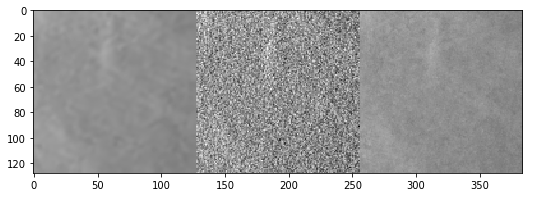

In [281]:
index = random.randint(0, len(output_result)-1)
plt.figure(figsize=(9,3))
print(np.mean(np.abs(output_result[index, 0, :, :]-style_batch[index, 0, :, :])))
plt.imshow(np.concatenate([output_result[index, 0, :, :], content_batch[index, 0, :, :], style_batch[index, 0, :, :]], axis=-1), cmap='gray')

In [3]:
def style_transfer(
        content=None,
        content_dir=None,
        content_size=512,
        style=None,
        style_dir=None,
        style_size=512,
        crop=None,
        preserve_color=None,
        alpha=1.0,
        style_interp_weights=None,
        mask=None,
        output_dir='output',
        save_ext='jpg',
        gpu=0,
        vgg_weights='models/vgg19_weights_normalized.h5',
        decoder_weights='models/decoder_weights.h5'):
    #assert bool(content) != bool(content_dir), 'Either content or content_dir should be given'
    #assert bool(style) != bool(style_dir), 'Either style or style_dir should be given'

    #if not os.path.exists(output_dir):
    #    print('Creating output dir at', output_dir)
    #    os.mkdir(output_dir)

    # Assume that it is either an h5 file or a name of a TensorFlow checkpoint
    decoder_in_h5 = False#"/home/pranjal/tf-adain/checkpoints/adain-240000"#decoder_weights.endswith('.h5')
    
    content_batch, style_batch = get_my_batch()
    
    print('Number of content images:', len(content_batch))
    print('Number of style images:', len(style_batch))

    data_format = 'channels_first'
    image, content, style, target, encoder, decoder = _build_graph(vgg_weights,
        decoder_weights if decoder_in_h5 else None, alpha, data_format=data_format)
    
    all_outputs = []
    #all_inputs 
    with tf.Session() as sess:
        if decoder_in_h5:
            sess.run(tf.global_variables_initializer())
        else:
            saver = tf.train.Saver()
            saver.restore(sess, decoder_weights)

        for k in range(len(content_batch)):
            content_image = content_batch[k]
            style_image   = style_batch[k]
            
            style_feature = sess.run(encoder, feed_dict={
                image: style_image[np.newaxis,:]
            })
            content_feature = sess.run(encoder, feed_dict={
                image: content_image[np.newaxis,:]
            })
            target_feature = sess.run(target, feed_dict={
                content: content_feature,
                style: style_feature
            })

            output = sess.run(decoder, feed_dict={
                content: content_feature,
                target: target_feature
            })
            
            all_outputs.append(output)
            #print("Output shape is ", output)
            
    return content_batch, style_batch, all_outputs

def _build_graph(vgg_weights, decoder_weights, alpha, data_format):
    if data_format == 'channels_first':
        image = tf.placeholder(shape=(None,3,None,None), dtype=tf.float32)
        content = tf.placeholder(shape=(1,512,None,None), dtype=tf.float32)
        style = tf.placeholder(shape=(1,512,None,None), dtype=tf.float32)
    else:
        image = tf.placeholder(shape=(None,None,None,3), dtype=tf.float32)
        content = tf.placeholder(shape=(1,None,None,512), dtype=tf.float32)
        style = tf.placeholder(shape=(1,None,None,512), dtype=tf.float32)

    target = adain(content, style, data_format=data_format)
    weighted_target = target * alpha + (1 - alpha) * content

    with open_weights(vgg_weights) as w:
        vgg = build_vgg(image, w, data_format=data_format)
        encoder = vgg['conv4_1']

    if decoder_weights:
        with open_weights(decoder_weights) as w:
            print(w)
            decoder = build_decoder(weighted_target, w, trainable=False,
                data_format=data_format)
    else:
        decoder = build_decoder(weighted_target, None, trainable=False,
            data_format=data_format)

    return image, content, style, target, encoder, decoder

In [ ]:
content_batch, style_batch, all_outputs = style_transfer()

all_outputs   = np.array(all_outputs)
content_batch = np.array(content_batch)
style_batch = np.array(style_batch)

print(all_outputs.shape, content_batch.shape, style_batch.shape)

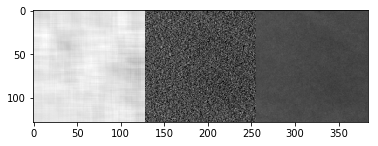

In [9]:
index = random.randint(0, len(all_outputs))
plt.imshow(np.concatenate([all_outputs[index, 0, 0, :, :], content_batch[index, 0, :, :,], style_batch[index, 0, :, :,]], axis=-1), cmap='gray')

In [ ]:
# CNN Models

def unet_double(pretrained_weights = None, input_size = (128, 128, 5), ):
    filter1 = 64
    filter2 = 128
    filter3 = 256
    filter4 = 512
    filter5 = 1024
    
    input1 = Input(input_size)
    input2 = Input((1, ))
    input3 = Input((1, ))
    
    hash_val1 = Dense(128, activation='relu')(input2)
    hash_val1 = Dense(1, activation='relu')(hash_val1)
    
    hash_val2 = Dense(128, activation='relu')(input3)
    hash_val2 = Dense(1, activation='relu')(hash_val2)
    
    hash_val = Multiply()([hash_val1, hash_val2])
    
    hash_val = Dense(128, activation='relu')(hash_val)
    hash_val = Dense(1, activation='relu')(hash_val)
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.5)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = [input1, input2, input3], output = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def unet_vanilla(pretrained_weights = None, input_size = (128, 128, 1), ):
    filter1 = 32
    filter2 = 64
    filter3 = 128
    filter4 = 256
    filter5 = 512
    
    input1 = Input(input_size)
    #input2 = Input((1, ))
    
    #hash_val = Dense(128, activation='relu')(input2)
    #hash_val = Dense(32, activation='relu')(hash_val)
    #hash_val = Dense(1, activation='relu')(hash_val)
    
    #input_mul = Multiply()([hash_val, input1])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    #conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    #conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    #conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    #pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.1)(conv5)
    #drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    #conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    #conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    #conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = input1#Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = input1, output = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def unet_two(pretrained_weights = None, input_size = (128, 128, 1), ):
    filter1 = 64
    filter2 = 128
    filter3 = 256
    filter4 = 512
    filter5 = 512
    
    input1 = Input(input_size)
    input2 = Input((1, ))
    
    hash_val = Dense(128, activation='relu')(input2)
    hash_val = Dropout(0.3)(hash_val)
    hash_val = Dense(32, activation='relu')(hash_val)
    hash_val = Dense(1, activation='relu')(hash_val)
    
    hash_val1 = Dense(128, activation='relu')(input2)
    hash_val1 = Dropout(0.3)(hash_val1)
    hash_val1 = Dense(32, activation='relu')(hash_val1)
    hash_val1 = Dense(1, activation='relu')(hash_val1)
    
    input_mul = Multiply()([hash_val, input1])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.2)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Dropout(0.2)(conv6)
    conv6  = Multiply()([hash_val1, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Dropout(0.2)(conv7)
    conv7  = Multiply()([hash_val1, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Dropout(0.2)(conv8)
    conv8  = Multiply()([hash_val1, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = input1#Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = [input1, input2], output = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def unet(pretrained_weights = None, input_size = (128, 128, 1), ):
    filter1 = 32
    filter2 = 64
    filter3 = 128
    filter4 = 256
    filter5 = 512
    
    input1 = Input(input_size)
    input2 = Input((1, ))
    
    hash_val = Dense(128, activation='relu')(input2)
    hash_val = Dropout(0.3)(hash_val)
    hash_val = Dense(32, activation='relu')(hash_val)
    hash_val = Dense(1, activation='relu')(hash_val)
    
    input_mul = Multiply()([hash_val, input1])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.2)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Dropout(0.2)(conv6)
    conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Dropout(0.2)(conv7)
    conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Dropout(0.2)(conv8)
    conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = input1#Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = [input1, input2], output = conv10)
    model.compile(optimizer = Adam(lr = 1e-5), loss = 'mse', metrics = ['mean_absolute_error'])
    
    #model.summary()
    return model

def unet_lstm(pretrained_weights = None, input_size = (128, 128, 2), ):
    filter1 = 32
    filter2 = 64
    filter3 = 128
    filter4 = 256
    filter5 = 512
    
    single_input = Input(input_size)
    
    input1 = Lambda(lambda x: x[:, :, :, 0])(single_input)
    input1 = Reshape([128, 128, 1])(input1)
    
    input2 = Lambda(lambda x: x[:, :, :, 1])(single_input)
    input2 = Flatten()(input2)
    input2 = Reshape([1, 128*128])(input2) 
    input2 = Lambda(lambda x: x[:, :, 0])(input2)
    
    hash_val = Dense(128, activation='relu')(input2)
    hash_val = Dense(1, activation='relu')(hash_val)
        
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.5)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #conv10 = Subtract()([input1, conv9])
    
    model  = Model(input = single_input, output = conv9)
    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def lstm_model():
    input_size = (5, 128, 128, 1)
    
    input1     = Input(input_size)
    input2     = Input((1, ))
    
    cnn_model  = unet()
    
    #time2       = TimeDistributed(cnn_model)(input1)
    
    lstm_out1   = ConvLSTM2D(filters=32, kernel_size=(3, 3), input_shape=(5, 128, 128, 1),
                             padding='same', activation=LeakyReLU(alpha=0.2), return_sequences=True)(input1)
    
    lstm_out2   = ConvLSTM2D(filters=1, kernel_size=(3, 3), padding='same', activation=LeakyReLU(alpha=0.2),
                            return_sequences=False)(lstm_out1)
    
    input_one = Lambda(lambda x: x[:, 4, :, :, :])(input1)
    input_one = Reshape([128, 128, 1])(input_one)
    
    cnn_out1   = cnn_model([lstm_out2, input2])
    
    final_out = Subtract()([input_one, cnn_out1])
    #lstm_out1   = ConvLSTM2D(filters=40, kernel_size=(3, 3), input_shape=(5, 128, 128, 1),
    #                         padding='same', activation=LeakyReLU(alpha=0.2), return_sequences=True)(lstm_out1)
    #lstm_out1   = ConvLSTM2D(filters=40, kernel_size=(3, 3), input_shape=(5, 128, 128, 1),
    #                         padding='same', activation=LeakyReLU(alpha=0.2), return_sequences=True)(lstm_out1)
    #lstm_out2   = ConvLSTM2D(filters=1, kernel_size=(3, 3), padding='same', activation=LeakyReLU(alpha=0.2),
    #                         return_sequences=False)(lstm_out1)
    
    #input_last  = Lambda(lambda x: x[:, 4, :, :, 0])(input1)
    #input_last  = Reshape([128, 128, 1])(input_last)
    
    #conv10      = Subtract()([input1, lstm_out2])
    
    time_model  = Model(input = [input1, input2], output = final_out)
    time_model.compile(optimizer = Adam(lr = 1e-4), 
                  loss = 'mean_absolute_error', 
                  metrics = ['mse'])
    
    return time_model

def conv_lstm_model():
    seq = Sequential()
    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       input_shape=(5, 128, 128, 1),
                       padding='same', return_sequences=True))
    #seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       padding='same', return_sequences=True))
    #seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       padding='same', return_sequences=True))
    #seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=1, kernel_size=(3, 3),
                       padding='same', return_sequences=False))
    #seq.add(BatchNormalization())

    #seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
    #               activation='sigmoid',
    #               padding='same', data_format='channels_last'))
    
    seq.compile(loss='binary_crossentropy', optimizer='adadelta')
    
    return seq

def unet_combined(pretrained_weights = None, input_size = (128, 128, 1)):
    base_model  = unet()
    base_model.load_weights("all-data-0-to-7-0.0005-5.h5")

    filter1 = 32
    filter2 = 32
    filter3 = 32
    
    input1 = Input(input_size)
    input2 = Input(input_size)
    
    input1_1 = Input((1, ))
    input1_2 = Input((1, ))
    input1_3 = Input((1, ))
    input1_4 = Input((1, ))
    input1_5 = Input((1, ))
    input1_6 = Input((1, ))
    input1_7 = Input((1, ))
    
    for t in base_model.layers:
        t.trainable = False
    
    w1    = Concatenate()([input1, input2])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(w1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter3, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    
    layer_output = base_model.layers[-4].output
    
    new_model    = Model(base_model.input, layer_output)
    
    r1 = new_model([input1, input1_1])
    r2 = new_model([input1, input1_2])
    r3 = new_model([input1, input1_3])
    r4 = new_model([input1, input1_4])
    r5 = new_model([input1, input1_5])
    r6 = new_model([input1, input1_6])
    r7 = new_model([input1, input1_7])
    
#     c1 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 0])(conv1))
#     c2 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 1])(conv1))
#     c3 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 2])(conv1))
#     c4 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 3])(conv1))
#     c5 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 4])(conv1))
#     c6 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 5])(conv1))
#     c7 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 6])(conv1))
    
    
#     q1 = Multiply()([conv1, r1])
#     q2 = Multiply()([conv1, r2])
#     q3 = Multiply()([conv1, r3])
#     q4 = Multiply()([conv1, r4])
#     q5 = Multiply()([conv1, r5])
#     q6 = Multiply()([conv1, r6])
#     q7 = Multiply()([conv1, r7])
    
    #ut   = Add()([q1, q2, q3, q4, q5, q6, q7])
    #ut   = Add()([c1, c2, c3, c4, c5, c6, c7])
    out   = Add()([r1, r2, r3, r4, r5, r6, r7])
    out   = Multiply()([conv1, out])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(out)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    out   = LeakyReLU(0.2)(conv1)
    
    #conv1 = Multiply()([hash_val, conv1])
    
    model1  = Model(input = [input1, input2, input1_1, input1_2, input1_3, input1_4, input1_5, input1_6, input1_7], output = out)
    
    model1.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    return model1

m = unet_two()
print(m.summary())

In [286]:
train_list = ['CE18', 'CE28', 'CE14', 'CE25', 'CE24', 'CE11', 'CE05', 'CE20', 'CE12', 'CE22'] # Add this later: 'CE25'
test_list  = ['CE03', 'CE07' 'CE18', 'CE27', 'CE17']

x_array = np.zeros([14560, 128, 128, 1], dtype='float16')
y_array = np.zeros([14560, 128, 128, 1], dtype='float16')
z_array = np.zeros([14560, 1], dtype='float16')

x_val_array = np.zeros([7000, 128, 128, 1], dtype='float16')
y_val_array = np.zeros([7000, 128, 128, 1], dtype='float16')
z_val_array = np.zeros([7000, 1], dtype='float16')

# x_array = np.zeros([6750, 128, 128, 1], dtype='float16')
# y_array = np.zeros([6750, 128, 128, 1], dtype='float16')
# z_array = np.zeros([6750, 1], dtype='float16')

# x_val_array = np.zeros([3875, 128, 128, 1], dtype='float16')
# y_val_array = np.zeros([3875, 128, 128, 1], dtype='float16')
# z_val_array = np.zeros([3875, 1], dtype='float16')

# x_array = np.zeros([175*7, 128, 128, 1], dtype='float16')
# y_array = np.zeros([175*7, 128, 128, 1], dtype='float16')
# z_array = np.zeros([175*7, 1], dtype='float16')

# x_val_array = np.zeros([175*3, 128, 128, 1], dtype='float16')
# y_val_array = np.zeros([175*3, 128, 128, 1], dtype='float16')
# z_val_array = np.zeros([175*3, 1], dtype='float16')


total_count = 0
for name in train_list[:-3]:
    a = np.load('/media/pranjal/BackupPlus/SIEMENS/DBT_recon_data/x_array_random-'+name+'-2.npy')
    x_array[total_count:total_count+a.shape[0], :, :, :] = a
    
    a = np.load('/media/pranjal/BackupPlus/SIEMENS/DBT_recon_data/y_array_random-'+name+'-2.npy')
    y_array[total_count:total_count+a.shape[0], :, :, :] = a
    
    a = np.load('/media/pranjal/BackupPlus/SIEMENS/DBT_recon_data/z_array_random-'+name+'-2.npy')
    z_array[total_count:total_count+a.shape[0],  :]     = a
    
    total_count = total_count + a.shape[0]
print(total_count)

total_count = 0
for name in train_list[-3:]:
    a = np.load('/media/pranjal/BackupPlus/SIEMENS/DBT_recon_data/x_array_random-'+name+'-2.npy')
    x_val_array[total_count:total_count+a.shape[0], :, :, :] = a
    
    a = np.load('/media/pranjal/BackupPlus/SIEMENS/DBT_recon_data/y_array_random-'+name+'-2.npy')
    y_val_array[total_count:total_count+a.shape[0], :, :, :] = a
    
    a = np.load('/media/pranjal/BackupPlus/SIEMENS/DBT_recon_data/z_array_random-'+name+'-2.npy')
    z_val_array[total_count:total_count+a.shape[0],  :]     = a
    
    total_count = total_count + a.shape[0]

print(total_count)

14560
7000


In [294]:
model = unet_two()
#model.load_weights('all-data-0-to-7-0.0005-5.h5')
checkpoints = ModelCheckpoint('all-data-random2-0-to-7-0.0005-5-two-more-filters.h5', 
                                              monitor='val_loss', verbose=0, save_best_only=True, 
                                              save_weights_only=False, mode='auto', period=1)

model.fit([x_array, z_array], y_array, 
          validation_data=([x_val_array, z_val_array], y_val_array), 
          batch_size=8, 
          epochs=10000, 
          callbacks=[checkpoints])

Train on 14560 samples, validate on 7000 samples
Epoch 1/10000
14560/14560 [==============================] - 226s 15ms/step - loss: 0.0011 - mean_squared_error: 3.3113e-06 - val_loss: 8.3673e-04 - val_mean_squared_error: 3.2194e-06
Epoch 2/10000
14560/14560 [==============================] - 226s 16ms/step - loss: 6.2226e-04 - mean_squared_error: 9.4178e-07 - val_loss: 7.4404e-04 - val_mean_squared_error: 2.2781e-06
Epoch 3/10000
14560/14560 [==============================] - 227s 16ms/step - loss: 5.6848e-04 - mean_squared_error: 7.5415e-07 - val_loss: 7.3955e-04 - val_mean_squared_error: 2.3796e-06
Epoch 4/10000
14560/14560 [==============================] - 228s 16ms/step - loss: 5.3984e-04 - mean_squared_error: 6.6235e-07 - val_loss: 7.0682e-04 - val_mean_squared_error: 2.0763e-06
Epoch 5/10000
14560/14560 [==============================] - 228s 16ms/step - loss: 5.1928e-04 - mean_squared_error: 5.9784e-07 - val_loss: 6.8486e-04 - val_mean_squared_error: 1.7954e-06
Epoch 6/10000
1

14560/14560 [==============================] - 227s 16ms/step - loss: 2.6330e-04 - mean_squared_error: 1.2676e-07 - val_loss: 6.4432e-04 - val_mean_squared_error: 1.4884e-06
Epoch 88/10000
14560/14560 [==============================] - 227s 16ms/step - loss: 2.6178e-04 - mean_squared_error: 1.2502e-07 - val_loss: 6.4244e-04 - val_mean_squared_error: 1.5035e-06
Epoch 89/10000
14560/14560 [==============================] - 227s 16ms/step - loss: 2.6161e-04 - mean_squared_error: 1.2515e-07 - val_loss: 6.3932e-04 - val_mean_squared_error: 1.4479e-06
Epoch 90/10000
14560/14560 [==============================] - 227s 16ms/step - loss: 2.6061e-04 - mean_squared_error: 1.2424e-07 - val_loss: 6.5346e-04 - val_mean_squared_error: 1.4826e-06
Epoch 91/10000
14560/14560 [==============================] - 227s 16ms/step - loss: 2.6034e-04 - mean_squared_error: 1.2369e-07 - val_loss: 6.3743e-04 - val_mean_squared_error: 1.4495e-06
Epoch 92/10000
14560/14560 [==============================] - 227s 16m

14560/14560 [==============================] - 227s 16ms/step - loss: 2.2257e-04 - mean_squared_error: 9.0249e-08 - val_loss: 6.4039e-04 - val_mean_squared_error: 1.3479e-06
Epoch 174/10000
14560/14560 [==============================] - 227s 16ms/step - loss: 2.2190e-04 - mean_squared_error: 8.9457e-08 - val_loss: 6.4200e-04 - val_mean_squared_error: 1.3846e-06
Epoch 175/10000
14560/14560 [==============================] - 227s 16ms/step - loss: 2.2189e-04 - mean_squared_error: 8.9590e-08 - val_loss: 6.4216e-04 - val_mean_squared_error: 1.3638e-06
Epoch 176/10000
14560/14560 [==============================] - 227s 16ms/step - loss: 2.2194e-04 - mean_squared_error: 8.9797e-08 - val_loss: 6.5209e-04 - val_mean_squared_error: 1.4378e-06
Epoch 177/10000
14560/14560 [==============================] - 227s 16ms/step - loss: 2.2086e-04 - mean_squared_error: 8.8628e-08 - val_loss: 6.5247e-04 - val_mean_squared_error: 1.4030e-06
Epoch 178/10000
14560/14560 [==============================] - 228

KeyboardInterrupt: 

In [424]:
result = model.predict([x_val_array, z_val_array], batch_size=8)
print(result.shape)

(7000, 128, 128, 1)


[0.63] [0.625] [0.621] [0.617] [0.616]
(128, 640) (128, 640) (128, 640) (384, 640)


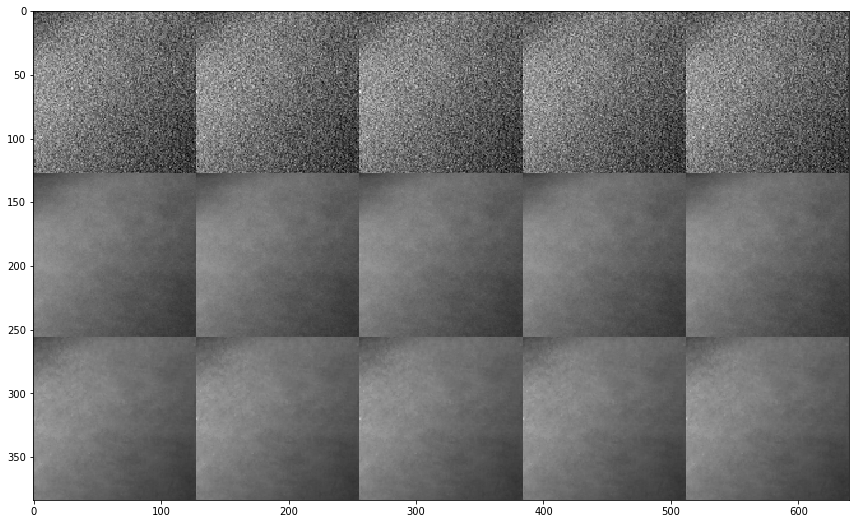

In [686]:
index = random.randint(100, len(x_val_array)-100)

print(z_val_array[index], z_val_array[index-1], z_val_array[index-2], z_val_array[index-3], z_val_array[index-4])
plt.figure(figsize=(27, 9))

t0 = np.concatenate([x_val_array[index, :, :, 0].astype('float32'), 
                           x_val_array[index-1, :, :, 0].astype('float32'),
                          x_val_array[index-2, :, :, 0].astype('float32'),
                          x_val_array[index-3, :, :, 0].astype('float32'),
                          x_val_array[index-4, :, :, 0].astype('float32')], axis=-1)

t1 = np.concatenate([y_val_array[index, :, :, 0].astype('float32'), 
                           y_val_array[index-1, :, :, 0].astype('float32'),
                          y_val_array[index-2, :, :, 0].astype('float32'),
                          y_val_array[index-3, :, :, 0].astype('float32'),
                          y_val_array[index-4, :, :, 0].astype('float32')], axis=-1)

t2 = np.concatenate([result[index, :, :, 0].astype('float32'), 
                           result[index-1, :, :, 0].astype('float32'),
                          result[index-2, :, :, 0].astype('float32'),
                          result[index-3, :, :, 0].astype('float32'),
                          result[index-4, :, :, 0].astype('float32')], axis=-1)
t4 = np.abs(t1-t2)
t3 = np.concatenate([t0, t1, t2], axis=0)
print(t0.shape, t1.shape, t2.shape, t3.shape)
plt.imshow(t3, cmap='gray')

# print(np.mean(np.abs(y_val_array[index, :, :, 0]-result[index, :, :, 0])))
# print(np.mean(np.abs(y_val_array[index-1, :, :, 0]-result[index-1, :, :, 0])))
# print(np.mean(np.abs(y_val_array[index-2, :, :, 0]-result[index-2, :, :, 0])))
# print(np.mean(np.abs(y_val_array[index-3, :, :, 0]-result[index-3, :, :, 0])))
# print(np.mean(np.abs(y_val_array[index-4, :, :, 0]-result[index-4, :, :, 0])))

In [751]:
allfiles = glob.glob("/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/duke_phantom/Cohort1/Cohort1.1_compressed/Cohort1.1_compressed/*.img")

count = 0
for f in allfiles:
    tx = int(f.split("/")[-1].split("_")[2])
    ty = int(f.split("/")[-1].split("_")[3])
    tz = int(f.split("/")[-1].split("_")[4].split(".")[0])
    
    print(f.split("/")[-1], tx, ty, tz)
    
    fid   = open(f, 'rb')
    data  = np.fromfile(fid, "uint8")
    image = data.reshape([tz, ty, tx])
    image = np.moveaxis(image, 0, -1)
    
    #print(np.unique(image.flatten()))
    
    for k in range(2, 6):
        #print(k)
        image[image == k] = 29
    
    image[image == 6]   = 2
    print(image.shape)
    
    image.tofile("/media/pranjal/BackupPlus/CEDBT/CHO-DATA/phantom-"+str(count)+"_"+str(image.shape[2])+"x"+str(image.shape[1])+"x"+str(image.shape[0])+".raw")
    count = count+1

CTB5673_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTA1632_6cm_635_256_433.img 635 256 433
(256, 635, 433)
CTA1459_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTB4500_8cm_804_337_435.img 804 337 435
(337, 804, 435)
CTB5885_8cm_804_337_435.img 804 337 435
(337, 804, 435)
CTA0297_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTA0725_8cm_804_337_435.img 804 337 435
(337, 804, 435)
CTB4651_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTA0663_8cm_804_337_435.img 804 337 435
(337, 804, 435)
CTA0446_8cm_804_337_435.img 804 337 435
(337, 804, 435)
CTA1920_6cm_635_256_433.img 635 256 433
(256, 635, 433)
CTB5410_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTA0338_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTA1438_8cm_804_337_435.img 804 337 435
(337, 804, 435)
CTB5282_8cm_804_337_435.img 804 337 435
(337, 804, 435)
CTA0457_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTB5859_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTA0302_8cm_804_337_435.img 804 337 435
(337, 80

(256, 635, 433)
CTA0445_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTA0357_5cm_602_216_337.img 602 216 337
(216, 602, 337)
CTA1641_6cm_635_256_433.img 635 256 433
(256, 635, 433)
CTA1148_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTA1851_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTA1310_6cm_635_256_433.img 635 256 433
(256, 635, 433)
CTB5769_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTB4698_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTB5881_8cm_804_337_435.img 804 337 435
(337, 804, 435)
CTB4826_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTB6016_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTA1673_7cm_716_297_416.img 716 297 416
(297, 716, 416)
CTA0475_8cm_804_337_435.img 804 337 435
(337, 804, 435)
CTB4863_5cm_602_216_337.img 602 216 337
(216, 602, 337)
CTA1222_8cm_804_337_435.img 804 337 435
(337, 804, 435)
CTA1452_8cm_804_337_435.img 804 337 435
(337, 804, 435)
CTB5651_8cm_804_337_435.img 804 337 435
(337, 804, 435)
CTA0750_8cm_804_337_435.img 804 

In [805]:
train_lesions = allfiles[:25]
val_lesions   = allfiles[25:35]
test_lesions  = allfiles[25:35]

print(len(train_lesions), len(val_lesions), len(test_lesions))

np.save("/home/pranjal/VICTRE/victre_breastmass/breastMass/train_lesions.npy", train_lesions)
np.save("/home/pranjal/VICTRE/victre_breastmass/breastMass/val_lesions.npy",  val_lesions)
np.save("/home/pranjal/VICTRE/victre_breastmass/breastMass/test_lesions.npy",  test_lesions)

25 10 10


In [ ]:
allfiles = glob.glob("/home/pranjal/VICTRE/victre_breastmass/breastMass/mass*.raw")
print(len(allfiles))
for f in allfiles:
    print(f.split("/")[-1])

In [820]:
# Reading the lesions array

train_lesions = np.load("/home/pranjal/VICTRE/victre_breastmass/breastMass/train_lesions.npy")
train_lesions_array = []

for name in train_lesions:
    temp = np.fromfile(name, dtype='uint8')
    t    = int(name.split("_")[-1].split(".")[0])
    temp = np.reshape(temp, [t, t, t])
    train_lesions_array.append(temp)

In [851]:
# Insert lesion loop

allfiles = glob.glob("/media/pranjal/BackupPlus/CEDBT/CHO-DATA/NO-LESION/*.raw")

def insert_lesion(image, z_slice):
    coord = []
    count = 0
    while(count < 4):
        k = count
        index = random.randint(0, len(train_lesions)-1)
        temp  = train_lesions_array[index]
        
        if temp.shape[0] > z_slice:
            continue
        
        #coord.append([z_slice-tx:z_slice+temp.shape[0]-tx, 150+k*120-tx:150+k*120+temp.shape[0]-tx, 100-tx:100+temp.shape[0]-tx])
        tx = int(temp.shape[0]/2)
        temp1 = image[z_slice-tx:z_slice+temp.shape[0]-tx, 150+k*120-tx:150+k*120+temp.shape[0]-tx, 100-tx:100+temp.shape[0]-tx]
        #print(temp1.shape, temp.shape)
        
        temp1[temp == 1] = 200
        image[z_slice-tx:z_slice+temp.shape[0]-tx, 150+k*120-tx:150+k*120+temp.shape[0]-tx, 100-tx:100+temp.shape[0]-tx] = temp1
        
        count = count+1
    
    count = 0 
    while(count < 4):
        k = count
        index = random.randint(0, len(train_lesions)-1)
        temp  = train_lesions_array[index]
        
        if temp.shape[0] > z_slice:
            continue
    
        tx = int(temp.shape[0]/2)
    
        temp1 = image[z_slice-tx:z_slice+temp.shape[0]-tx, 150+k*120-tx:150+k*120+temp.shape[0]-tx, 200-tx:200+temp.shape[0]-tx]
        #print(temp1.shape, temp.shape)
        
        temp1[temp == 1] = 200
        image[z_slice-tx:z_slice+temp.shape[0]-tx, 150+k*120-tx:150+k*120+temp.shape[0]-tx, 200-tx:200+temp.shape[0]-tx] = temp1
        
        count = count+1
        
    return image
    
for f in allfiles:
    data = np.fromfile(f, dtype='uint8')
    
    tx = int(f.split("/")[-1].split("_")[1].split("x")[0])
    ty = int(f.split("/")[-1].split("_")[1].split("x")[1])
    tz = int(f.split("/")[-1].split("_")[1].split("x")[2].split(".")[0])
    
    name = f.split("/")[-1]
    print(name)
    
    image = data.reshape([tz, ty, tx])
    
    if image.shape[0] < 280:
        image = insert_lesion(image, 130)
    else:
        image = insert_lesion(image, 150)
    
    image.tofile("/media/pranjal/BackupPlus/CEDBT/CHO-DATA/WITH-LESION/"+name)
    

phantom-132_416x716x297.raw
phantom-157_416x716x297.raw
phantom-40_416x716x297.raw
phantom-36_435x804x337.raw
phantom-93_435x804x337.raw
phantom-122_416x716x297.raw
phantom-149_433x635x256.raw
phantom-75_435x804x337.raw
phantom-30_433x635x256.raw
phantom-121_435x804x337.raw
phantom-137_433x635x256.raw
phantom-119_416x716x297.raw
phantom-167_416x716x297.raw
phantom-32_416x716x297.raw
phantom-63_433x635x256.raw
phantom-95_435x804x337.raw
phantom-113_433x635x256.raw
phantom-92_435x804x337.raw
phantom-5_416x716x297.raw
phantom-97_435x804x337.raw
phantom-155_435x804x337.raw
phantom-52_435x804x337.raw
phantom-29_435x804x337.raw
phantom-15_416x716x297.raw
phantom-110_416x716x297.raw
phantom-0_416x716x297.raw
phantom-59_435x804x337.raw
phantom-145_416x716x297.raw
phantom-82_435x804x337.raw
phantom-117_416x716x297.raw
phantom-147_416x716x297.raw
phantom-176_435x804x337.raw
phantom-57_416x716x297.raw
phantom-78_435x804x337.raw
phantom-89_416x716x297.raw
phantom-3_435x804x337.raw
phantom-4_435x80

In [848]:
print(image.shape)

(297, 716, 416)


In [788]:
image[150-78:150+78, 200-78:200+78, 100-78:100+78] = temp

In [785]:
temp[a == 1] = 200

In [780]:
temp = image[150-78:150+78, 200-78:200+78, 100-78:100+78]

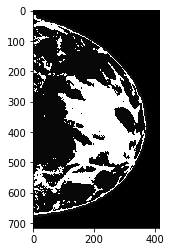

In [808]:
plt.imshow(a[70, :, :], cmap='gray')

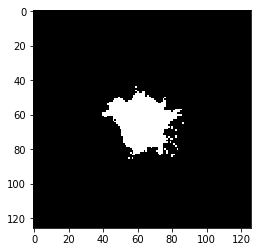

In [819]:
plt.imshow(temp[50, :, :], cmap='gray')